In [273]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_lags, make_lags, make_leads
from dfply import *
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split


%matplotlib inline
warnings.filterwarnings("ignore")

In [274]:
df = pd.read_excel('../data/Assignment 3 - timeseries_data.xlsx', 
                   converters= {'DATETIME': pd.to_datetime})

df.head()

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
0 2017-01-01 01:00:00           23.3575           2155.31   
1 2017-01-01 02:00:00           21.4650           2313.81   
2 2017-01-01 03:00:00           20.7350           2587.68   
3 2017-01-01 04:00:00           20.2700           2748.65   
4 2017-01-01 05:00:00           20.1200           2757.49   

   ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
0                          0.0    29485.791355           1 2017-01-01   
1                          0.0    28911.565913           2 2017-01-01   
2                          0.0    28238.258175           3 2017-01-01   
3                          0.0    27821.000513           4 2017-01-01   
4                          0.0    27646.942413           5 2017-01-01   

  PEAKTYPE    MONTH  YEAR  
0  OFFPEAK  JANUARY  2017  
1  OFFPEAK  JANUARY  2017  
2  OFFPEAK  JANUARY  2017  
3  OFFPEAK  JANUARY  2017  
4  OFFPEAK  JANUARY  2017

# 1. EDA

## 1.1 Data cleaning

### 1.1.1 Drop duplicates

In [275]:
df.DATETIME.is_unique

False

**There are duplicates in DateTime.**

In [276]:
df[df.DATETIME.duplicated()]

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
7393 2017-11-05 02:00:00           16.3525               NaN   

      ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
7393                          NaN     33109.71394           2 2017-11-05   

     PEAKTYPE     MONTH  YEAR  
7393  OFFPEAK  NOVEMBER  2017

In [277]:
df.iloc[7392:7394, :]

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
7392 2017-11-05 02:00:00           16.5675               NaN   
7393 2017-11-05 02:00:00           16.3525               NaN   

      ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
7392                          NaN    34032.269078           2 2017-11-05   
7393                          NaN    33109.713940           2 2017-11-05   

     PEAKTYPE     MONTH  YEAR  
7392  OFFPEAK  NOVEMBER  2017  
7393  OFFPEAK  NOVEMBER  2017

* **There are two rows with DateTime '2017-11-05 02:00:00'.**
* **Delete the second row.**

In [278]:
df = df.drop_duplicates(subset=['DATETIME'], keep='first')
df.iloc[7392:7394, :]

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
7392 2017-11-05 02:00:00           16.5675               NaN   
7394 2017-11-05 03:00:00           16.0150          13214.79   

      ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
7392                          NaN    34032.269078           2 2017-11-05   
7394                          0.0    32471.632580           3 2017-11-05   

     PEAKTYPE     MONTH  YEAR  
7392  OFFPEAK  NOVEMBER  2017  
7394  OFFPEAK  NOVEMBER  2017

### 1.1.2 Replace NaN with 0

In [279]:
df.fillna(0, inplace=True)

### 1.1.3 Encode `PeakType` and `MONTH`

In [280]:
encode_list = {"PEAKTYPE": {"WDPEAK": 0, "OFFPEAK": 1, "WEPEAK": 2},
               "MONTH": {'JANUARY': 1, 'FEBRUARY': 2, 'MARCH': 3, 'APRIL': 4, 
                                 'MAY': 5, 'JUNE': 6, 'JULY': 7, 'AUGUST': 8, 
                                 'SEPTEMBER': 9, 'OCTOBER': 10, 'NOVEMBER': 11, 'DECEMBER': 12}}

df = df.replace(encode_list)
df.head()

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
0 2017-01-01 01:00:00           23.3575           2155.31   
1 2017-01-01 02:00:00           21.4650           2313.81   
2 2017-01-01 03:00:00           20.7350           2587.68   
3 2017-01-01 04:00:00           20.2700           2748.65   
4 2017-01-01 05:00:00           20.1200           2757.49   

   ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
0                          0.0    29485.791355           1 2017-01-01   
1                          0.0    28911.565913           2 2017-01-01   
2                          0.0    28238.258175           3 2017-01-01   
3                          0.0    27821.000513           4 2017-01-01   
4                          0.0    27646.942413           5 2017-01-01   

   PEAKTYPE  MONTH  YEAR  
0         1      1  2017  
1         1      1  2017  
2         1      1  2017  
3         1      1  2017  
4         1      1  2017

## 1.2 Data insights

In [281]:
df.shape

(14986, 10)

* **Dataset comprises of 14986 observations and 12 characteristics.**  
* **Out of which one is dependent variable and rest 9 are independent variables.**

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14986 entries, 0 to 14986
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   DATETIME                     14986 non-null  datetime64[ns]
 1   HB_NORTH (RTLMP)             14986 non-null  float64       
 2   ERCOT (WIND_RTI)             14986 non-null  float64       
 3   ERCOT (GENERATION_SOLAR_RT)  14986 non-null  float64       
 4   ERCOT (RTLOAD)               14986 non-null  float64       
 5   HOURENDING                   14986 non-null  int64         
 6   MARKETDAY                    14986 non-null  datetime64[ns]
 7   PEAKTYPE                     14986 non-null  int64         
 8   MONTH                        14986 non-null  int64         
 9   YEAR                         14986 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(4)
memory usage: 1.3 MB


In [283]:
df.PEAKTYPE.value_counts()

0    6966
1    4996
2    3024
Name: PEAKTYPE, dtype: int64

**There are three types of peak: weekday, weekend, off-peak.**

## 1.3 Summary statistics

In [284]:
df.describe()

HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  ERCOT (GENERATION_SOLAR_RT)  \
count      14986.000000      14986.000000                 14986.000000   
mean          25.767045       7530.425757                   291.931262   
std           46.363428       3994.247698                   370.900472   
min          -17.860000          0.000000                     0.000000   
25%           18.042500       4134.295000                     0.000000   
50%           20.057500       7279.545000                    22.000000   
75%           25.030000      10851.460000                   608.595000   
max         2809.357500      20350.400000                  1257.540000   

       ERCOT (RTLOAD)    HOURENDING      PEAKTYPE         MONTH          YEAR  
count    14986.000000  14986.000000  14986.000000  14986.000000  14986.000000  
mean     42372.291743     12.496463      0.736954      5.813826   2017.415521  
std       9874.379211      6.922009      0.772961      3.195118      0.492828  
min      25566.511248      1.000000      0.000000      1.000000   2017.000000  
25%      35431.952888      6.000000      0.000000      3.000000   2017.000000  
50%      39934.569371     12.000000      1.000000      6.000000   2017.000000  
75%      47873.960846     18.000000      1.000000      8.000000   2018.000000  
max      73264.662123     24.000000      2.000000     12.000000   2018.000000

* **`HB_NORTH (RTLMP)`: There is notably a large difference between 75% quantile and max value, suggesting that there are extreme value, Outliers.**
* **`ERCOT (GENERATION_SOLAR_RT)`: Not only there's a large difference between max and 75% q, but also the mean value is much larger than median value, indicating there are outliers.**

## 1.4 Data visualization

### 1.4.1 Correlation

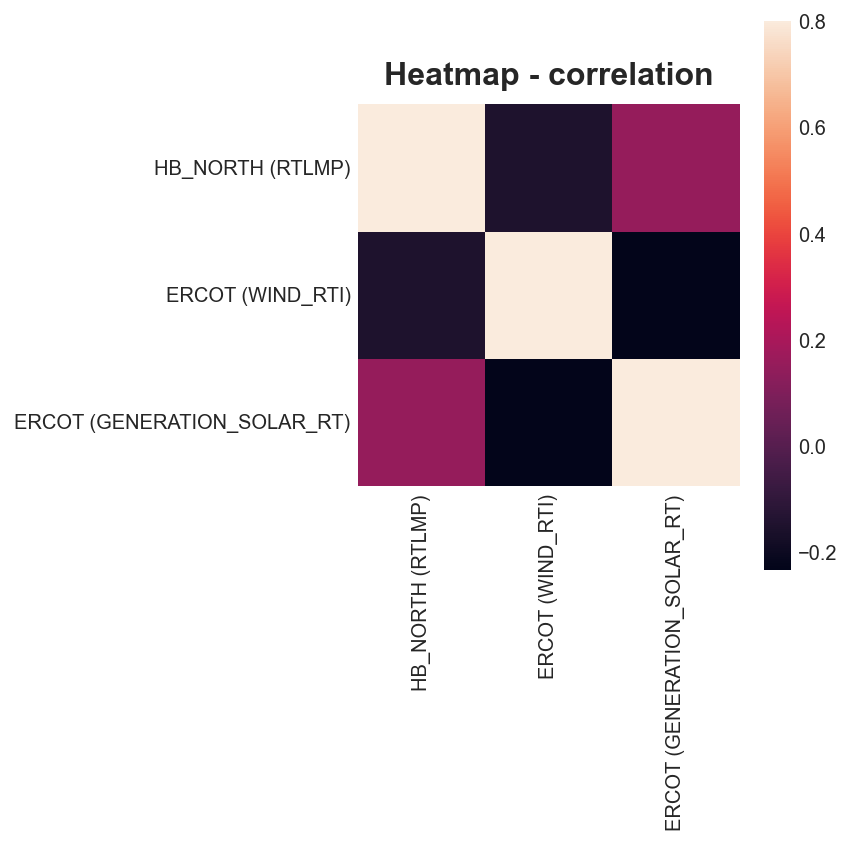

In [285]:
corrmat = df[['HB_NORTH (RTLMP)', 'ERCOT (WIND_RTI)', 'ERCOT (GENERATION_SOLAR_RT)']].corr()

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(corrmat, vmax=.8, square=True)

ax.set_title('Heatmap - correlation'); 

**These three variables are not correlated.**

### 1.4.2 Outliers

<AxesSubplot:xlabel='ERCOT (GENERATION_SOLAR_RT)'>

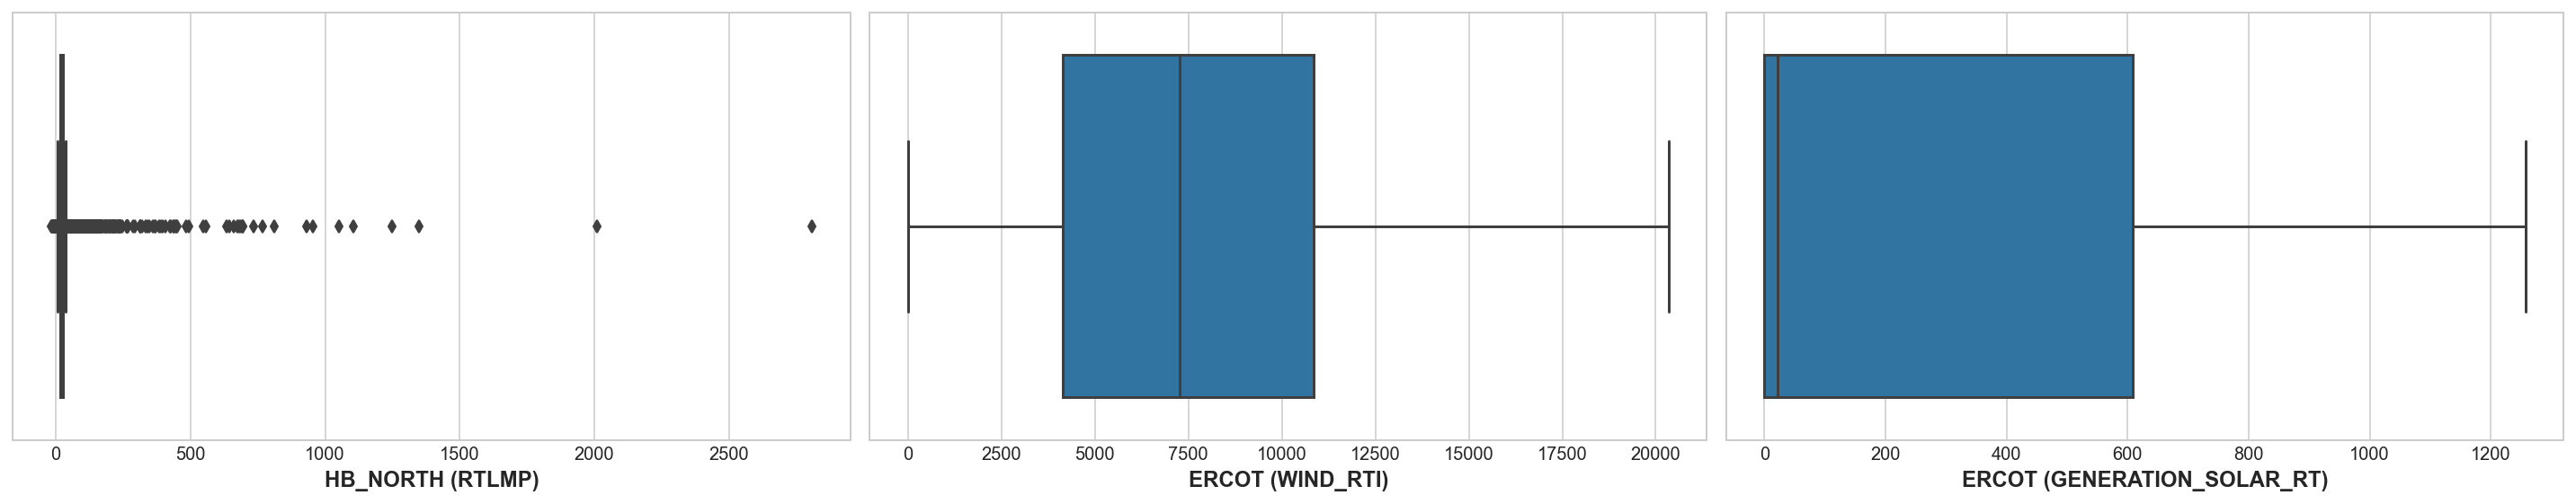

In [286]:
fig, ax = plt.subplots(1, 3, figsize=(20,4))

sns.boxplot(x=df['HB_NORTH (RTLMP)'], ax=ax[0])
sns.boxplot(x=df['ERCOT (WIND_RTI)'], ax=ax[1])
sns.boxplot(x=df['ERCOT (GENERATION_SOLAR_RT)'], ax=ax[2])

**From this plot we can tell 'HB_NORTH (RTLMP)' has many outliers, and 'ERCOT (GENERATION_SOLAR_RT)' is skewly distributed.**

###  1.4.3 Distribution

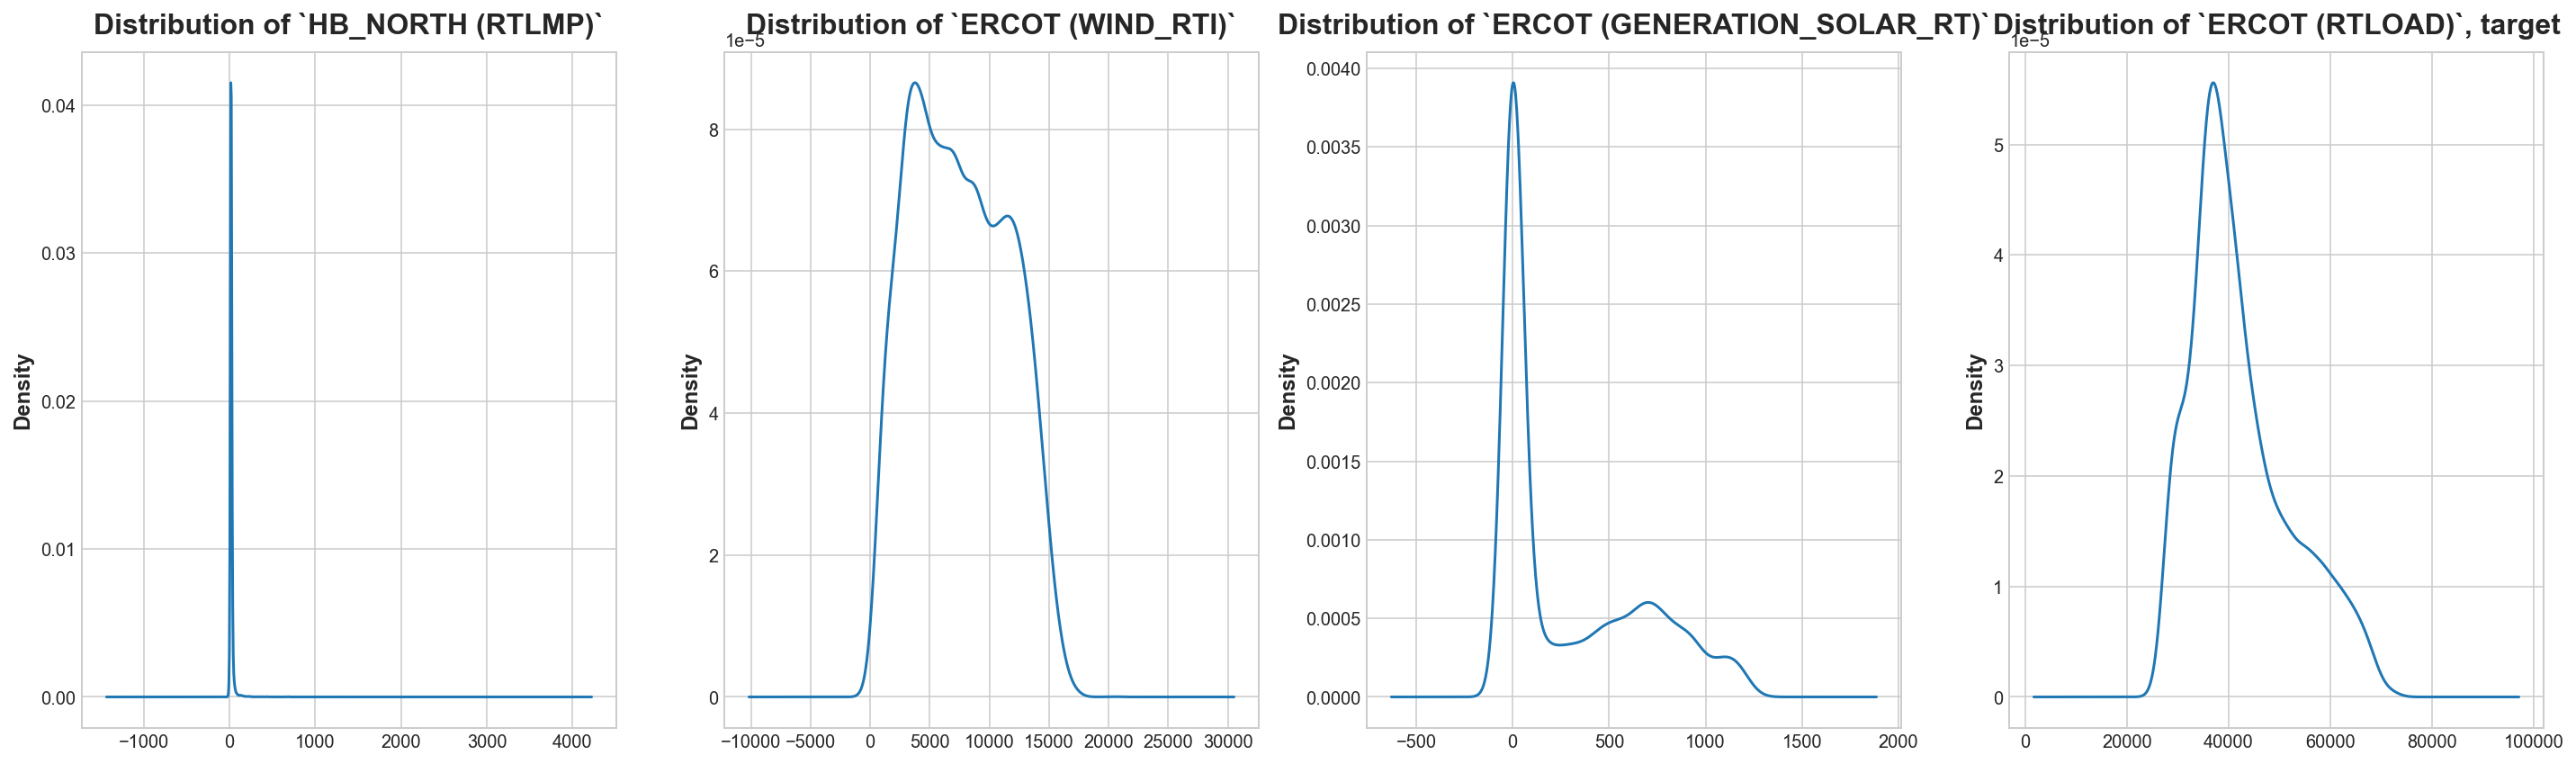

In [287]:
fig, ax = plt.subplots(1, 4, figsize=(20,6))

df['HB_NORTH (RTLMP)'].plot.kde(ax=ax[0])
df['ERCOT (WIND_RTI)'].plot.kde(ax=ax[1])
df['ERCOT (GENERATION_SOLAR_RT)'].plot.kde(ax=ax[2])
df['ERCOT (RTLOAD)'].plot.kde(ax=ax[3])

ax[0].set_title('Distribution of `HB_NORTH (RTLMP)`')
ax[1].set_title('Distribution of `ERCOT (WIND_RTI)`')
ax[2].set_title('Distribution of `ERCOT (GENERATION_SOLAR_RT)`')
ax[3].set_title('Distribution of `ERCOT (RTLOAD)`, target');

**The distributions of 'HB_NORTH (RTLMP)' and 'ERCOT (GENERATION_SOLAR_RT)' are far from normal distribution.**

## 1.5 Time Series trend

### 1.5.1 Trend

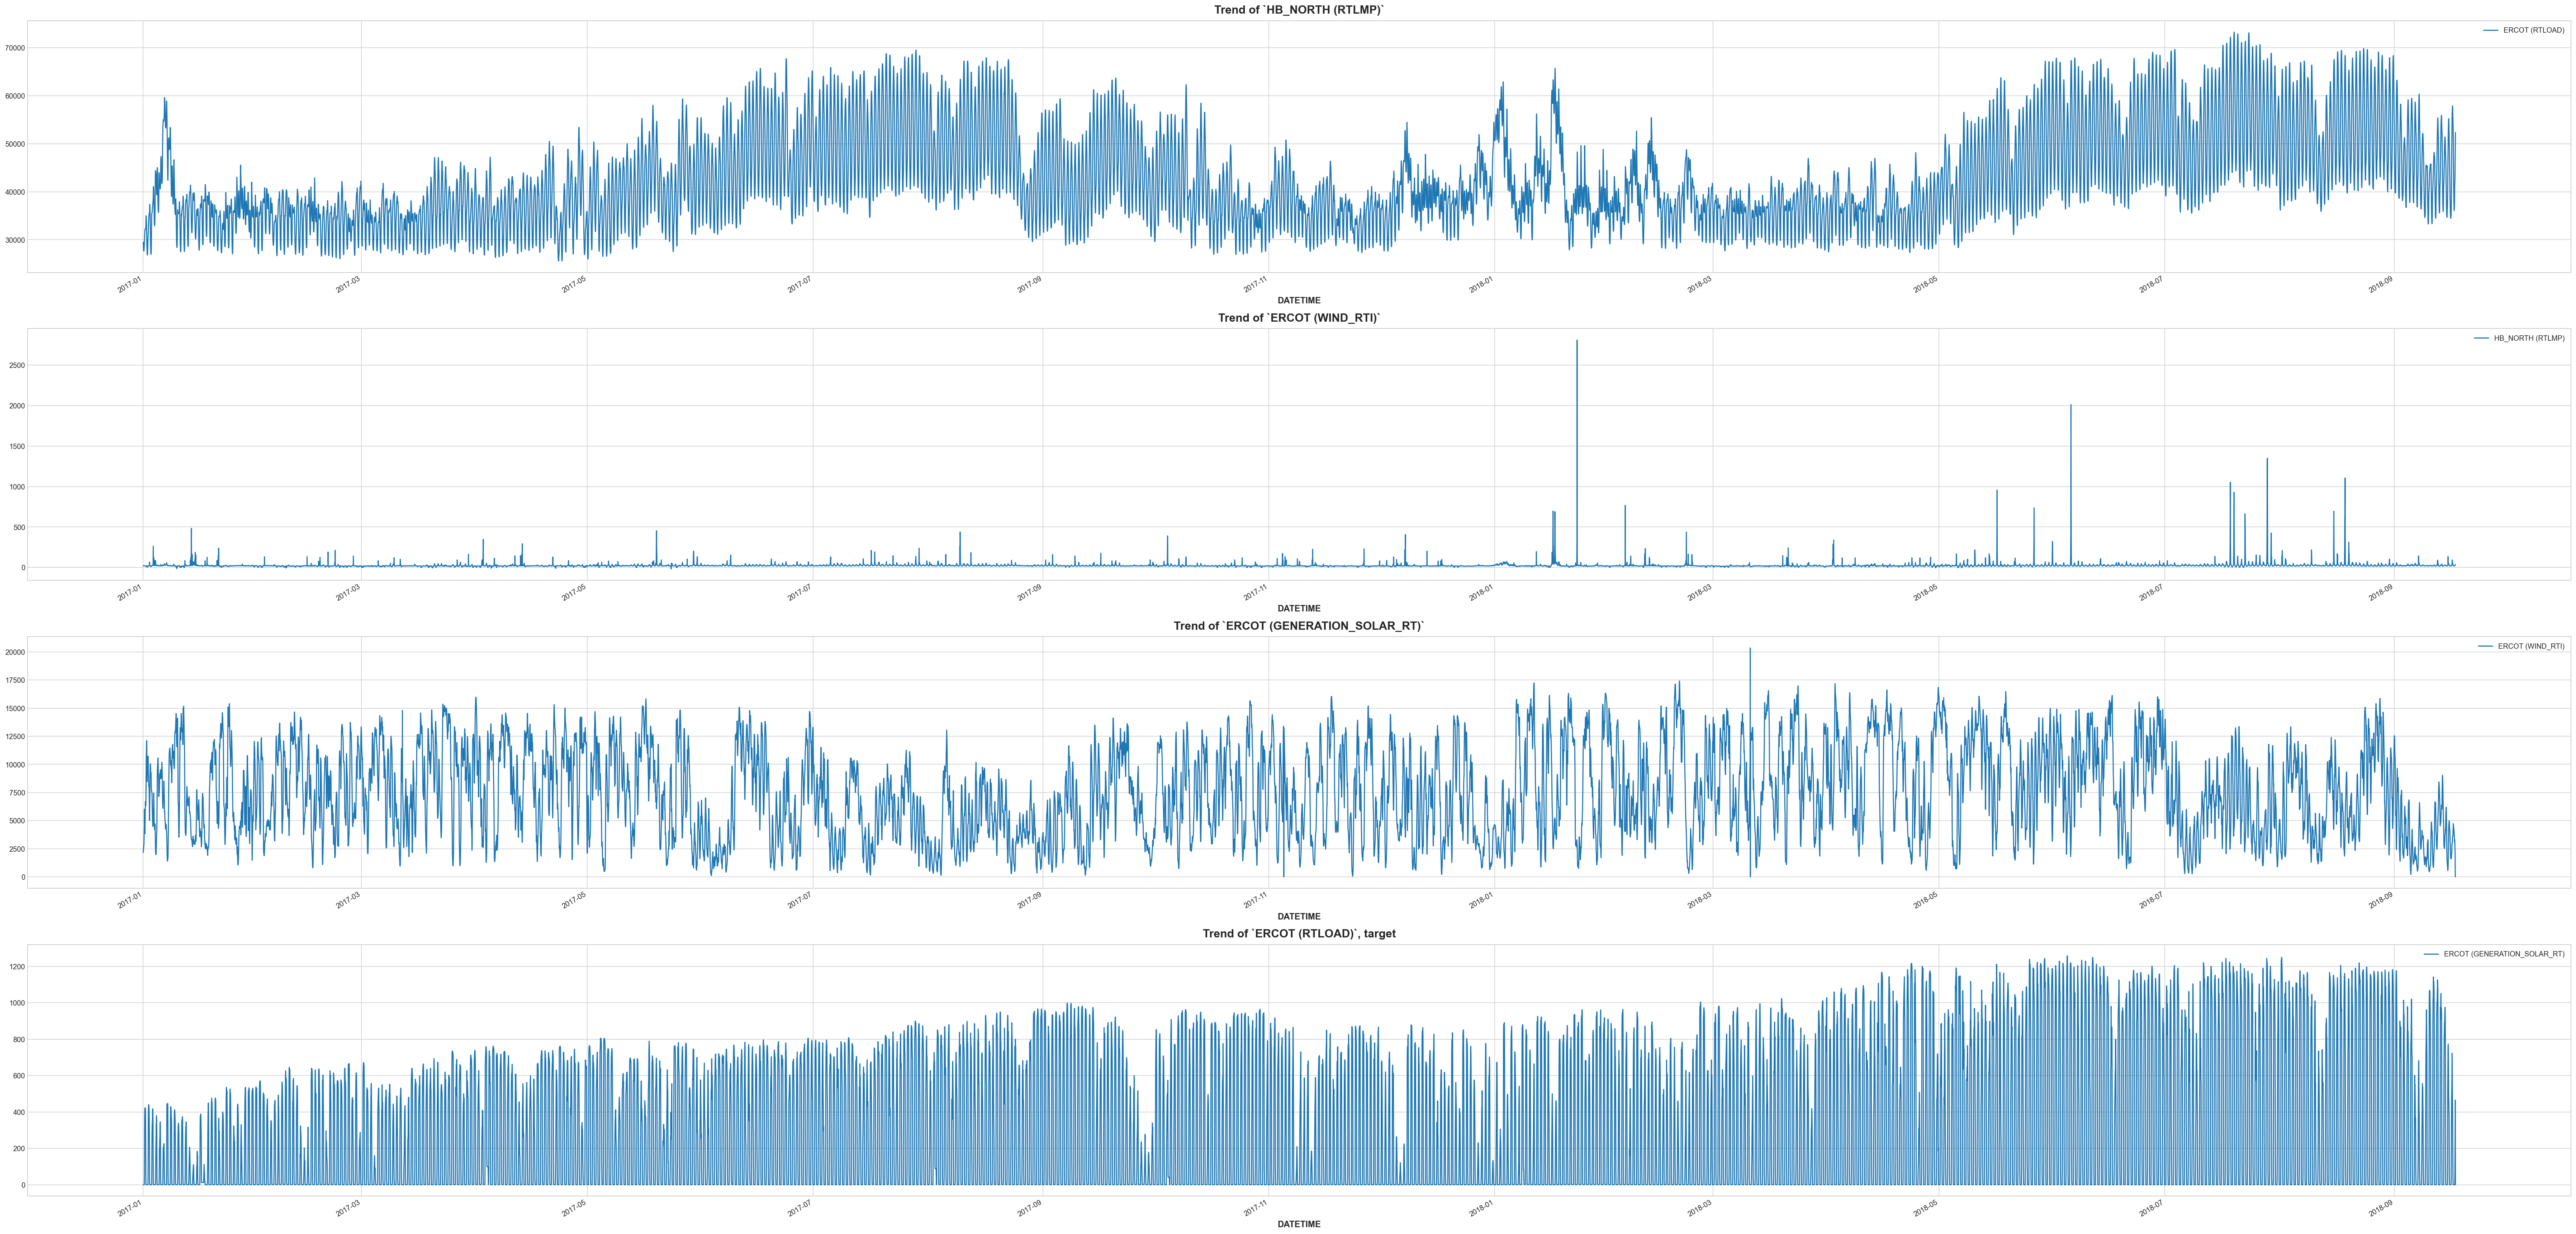

In [288]:
fig, ax = plt.subplots(4, 1, figsize=(50,24))

df.plot(x='DATETIME', y='ERCOT (RTLOAD)', ax=ax[0])
ax[1] = df.plot(x='DATETIME', y='HB_NORTH (RTLMP)', ax=ax[1])
ax[2] = df.plot(x='DATETIME', y='ERCOT (WIND_RTI)', ax=ax[2])
ax[3] = df.plot(x='DATETIME', y='ERCOT (GENERATION_SOLAR_RT)', ax=ax[3])

ax[0].set_title('Trend of `HB_NORTH (RTLMP)`')
ax[1].set_title('Trend of `ERCOT (WIND_RTI)`')
ax[2].set_title('Trend of `ERCOT (GENERATION_SOLAR_RT)`')
ax[3].set_title('Trend of `ERCOT (RTLOAD)`, target');

### 1.5.2 Trend in different time frames

In [289]:
df_24 = df.groupby(['HOURENDING']).mean()['ERCOT (RTLOAD)']
df_peak = df.groupby(['PEAKTYPE']).mean()['ERCOT (RTLOAD)']
df_12 = df.groupby(['MONTH']).mean()['ERCOT (RTLOAD)']
df_year = df.groupby(['YEAR']).mean()['ERCOT (RTLOAD)']

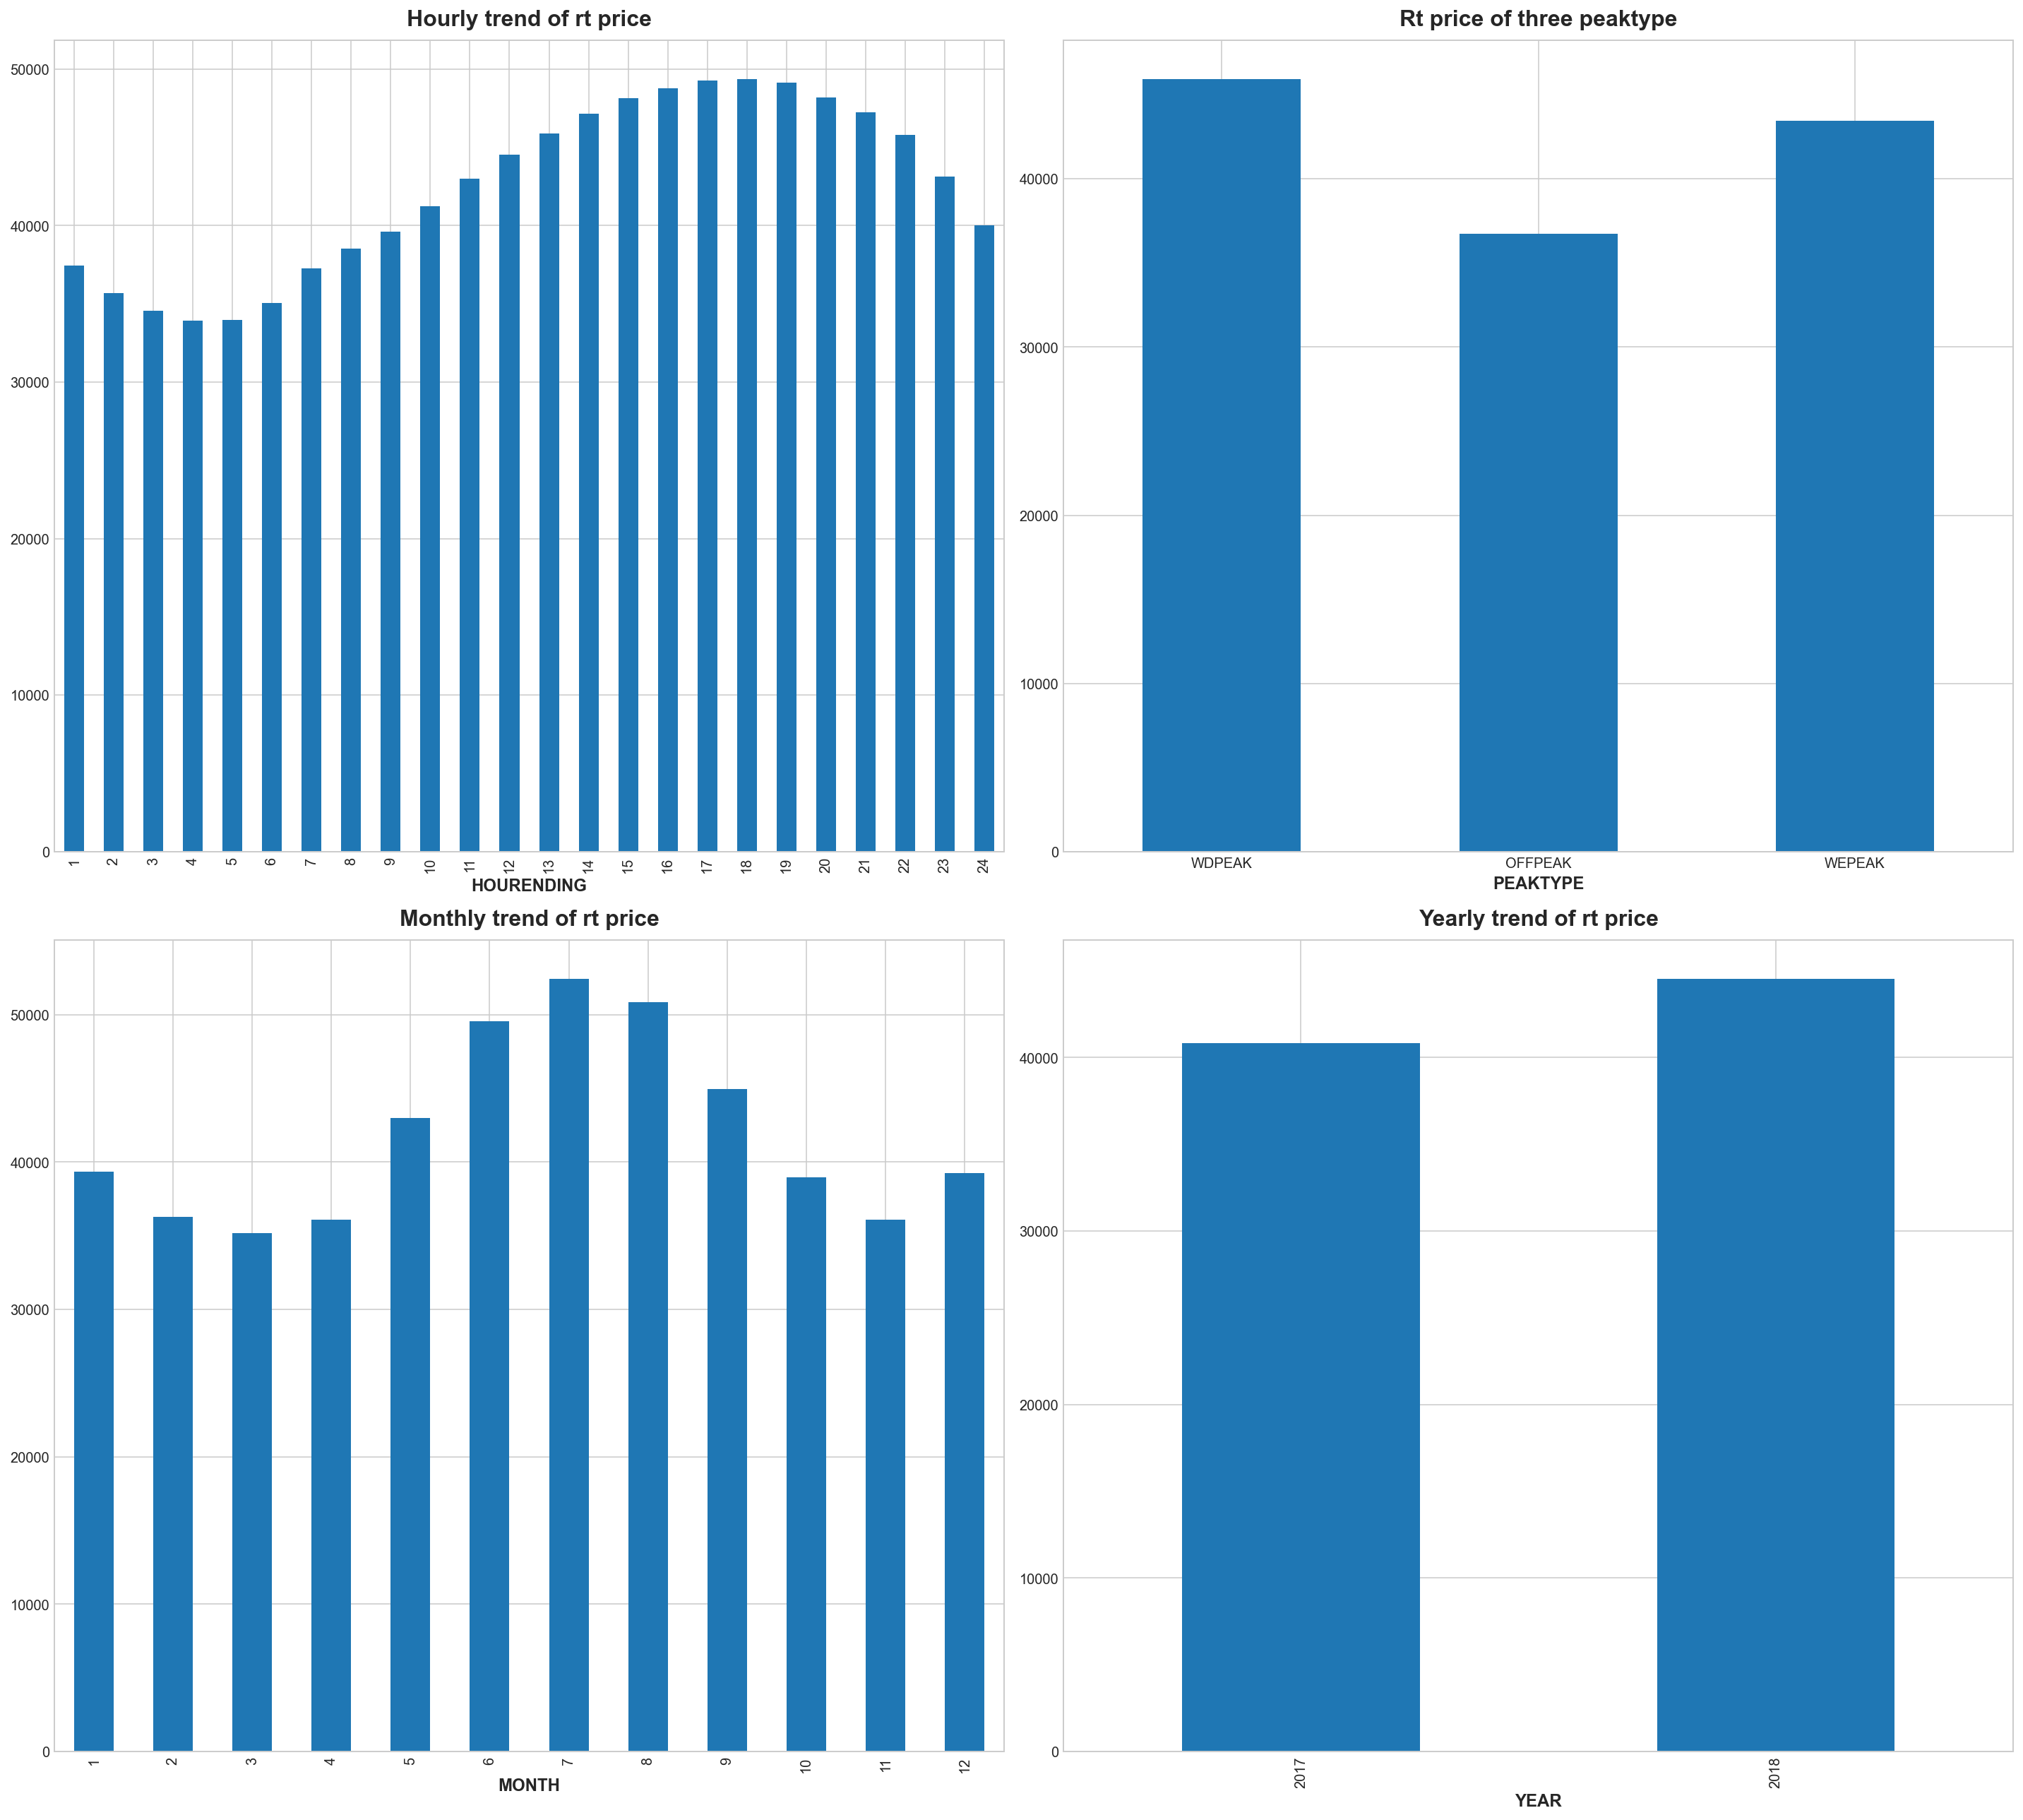

In [290]:
fig, axs = plt.subplots(2, 2, figsize=(20, 18))
ax = axs.ravel()

df_24.plot(kind='bar', stacked=True, ax=ax[0])
df_peak.plot(kind='bar', stacked=True, ax=ax[1])
df_12.plot(kind='bar', stacked=True, ax=ax[2])
df_year.plot(kind='bar', stacked=True, ax=ax[3])

ax[1].set_xticklabels(["WDPEAK", "OFFPEAK", "WEPEAK"], rotation=0)

ax[0].set_title('Hourly trend of rt price')
ax[1].set_title('Rt price of three peaktype')
ax[2].set_title('Monthly trend of rt price')
ax[3].set_title('Yearly trend of rt price');

* **Hour: From 5am to 18pm, the price is increasing and reach the peak at 18pm.**
* **Peaktype: 'weekday' has the highest price and 'offpeak' has the lowest.**
* **Month: From January to March and from August to November, the price is decreasing and reach the lowest price of the year in March; From April to July, it's increasing. The price is relatively high in Summer and reaches the highest in July.**
* **Year: The average price grows from 2017 to 2018.**

### 1.5.3 Compare 2017 and 2018 month-wise

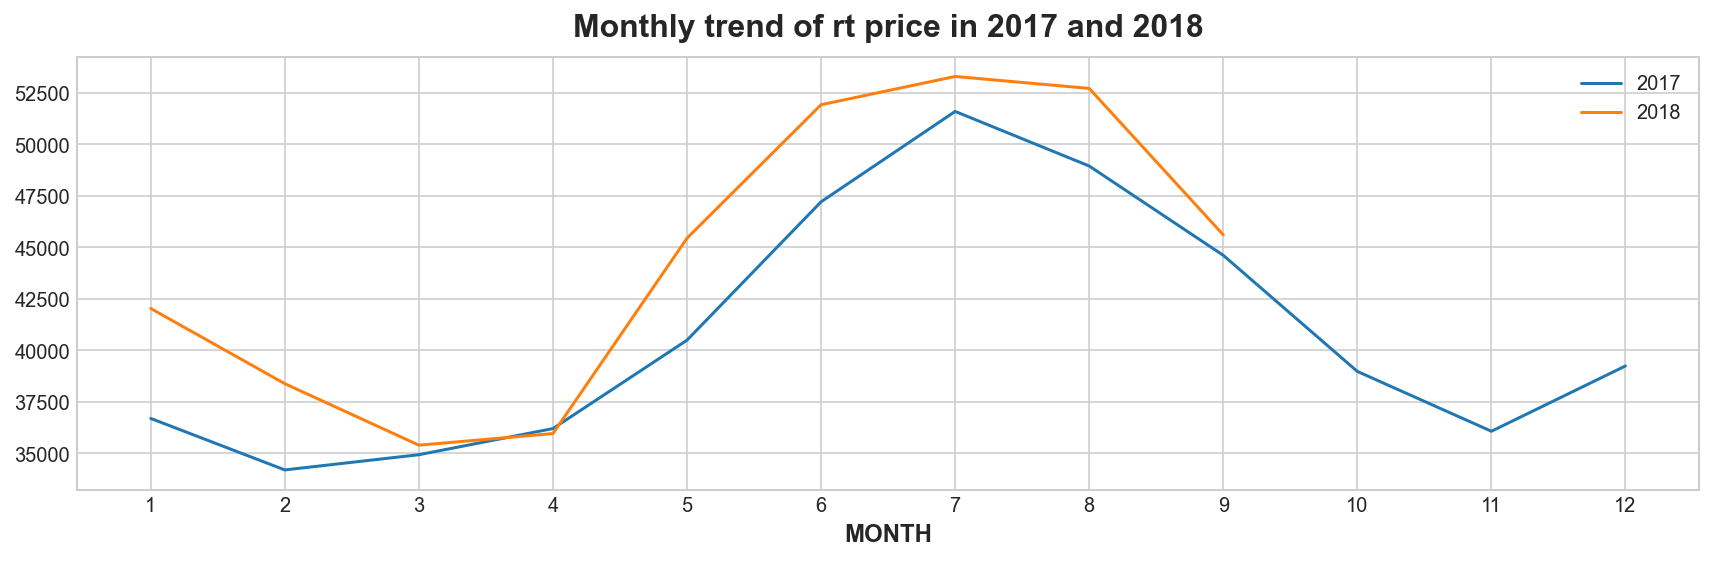

In [291]:
df_12_2017 = df[df.YEAR==2017].groupby(['MONTH']).mean()['ERCOT (RTLOAD)']
df_12_2018 = df[df.YEAR==2018].groupby(['MONTH']).mean()['ERCOT (RTLOAD)']

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

df_12_2017.plot(label='2017')
df_12_2018.plot(label='2018')

ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_title('Monthly trend of rt price in 2017 and 2018')
plt.legend()
plt.show();

* **Clearly, the pattern repeats within both 2017 and 2018.**
* **Generally, the price increases from 2017 to 2017.**

### 1.5.4 Outliers month-wise and year-wise

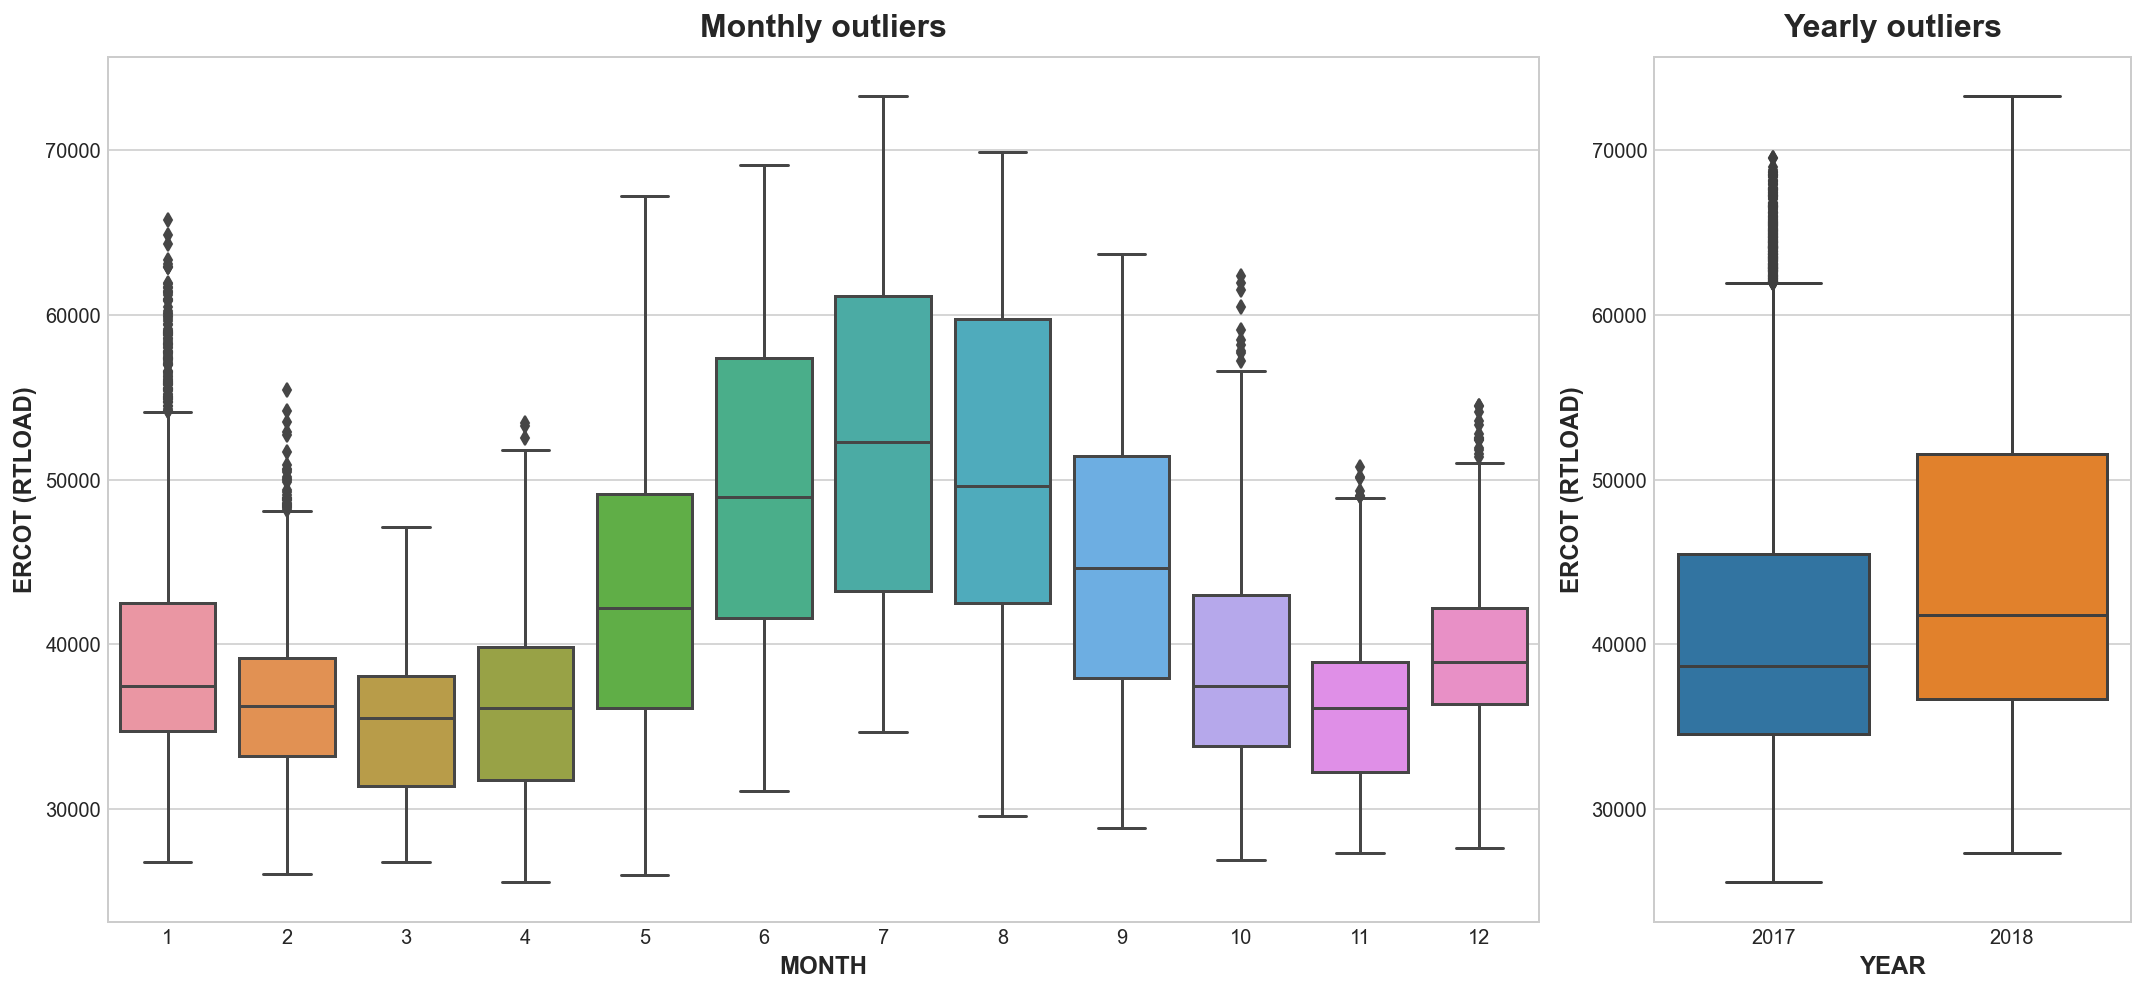

In [292]:
fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])     # To set different size for subplots.
ax1 = plt.subplot(gs[1])

sns.boxplot(x='MONTH', y='ERCOT (RTLOAD)', data=df, ax=ax0)
sns.boxplot(x='YEAR', y='ERCOT (RTLOAD)', data=df, ax=ax1)

ax0.set_title('Monthly outliers')
ax1.set_title('Yearly outliers');

* **There are some outliers in January, February, April, October, November and December.**
* **There are outliers in 2017, but not in 2018.**

# 2. Forecast model to predict RTLMP

In [293]:
df['Time'] = np.arange(len(df.index))
df.head()

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
0 2017-01-01 01:00:00           23.3575           2155.31   
1 2017-01-01 02:00:00           21.4650           2313.81   
2 2017-01-01 03:00:00           20.7350           2587.68   
3 2017-01-01 04:00:00           20.2700           2748.65   
4 2017-01-01 05:00:00           20.1200           2757.49   

   ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
0                          0.0    29485.791355           1 2017-01-01   
1                          0.0    28911.565913           2 2017-01-01   
2                          0.0    28238.258175           3 2017-01-01   
3                          0.0    27821.000513           4 2017-01-01   
4                          0.0    27646.942413           5 2017-01-01   

   PEAKTYPE  MONTH  YEAR  Time  
0         1      1  2017     0  
1         1      1  2017     1  
2         1      1  2017     2  
3         1      1  2017     3  
4         1      1  2017     4

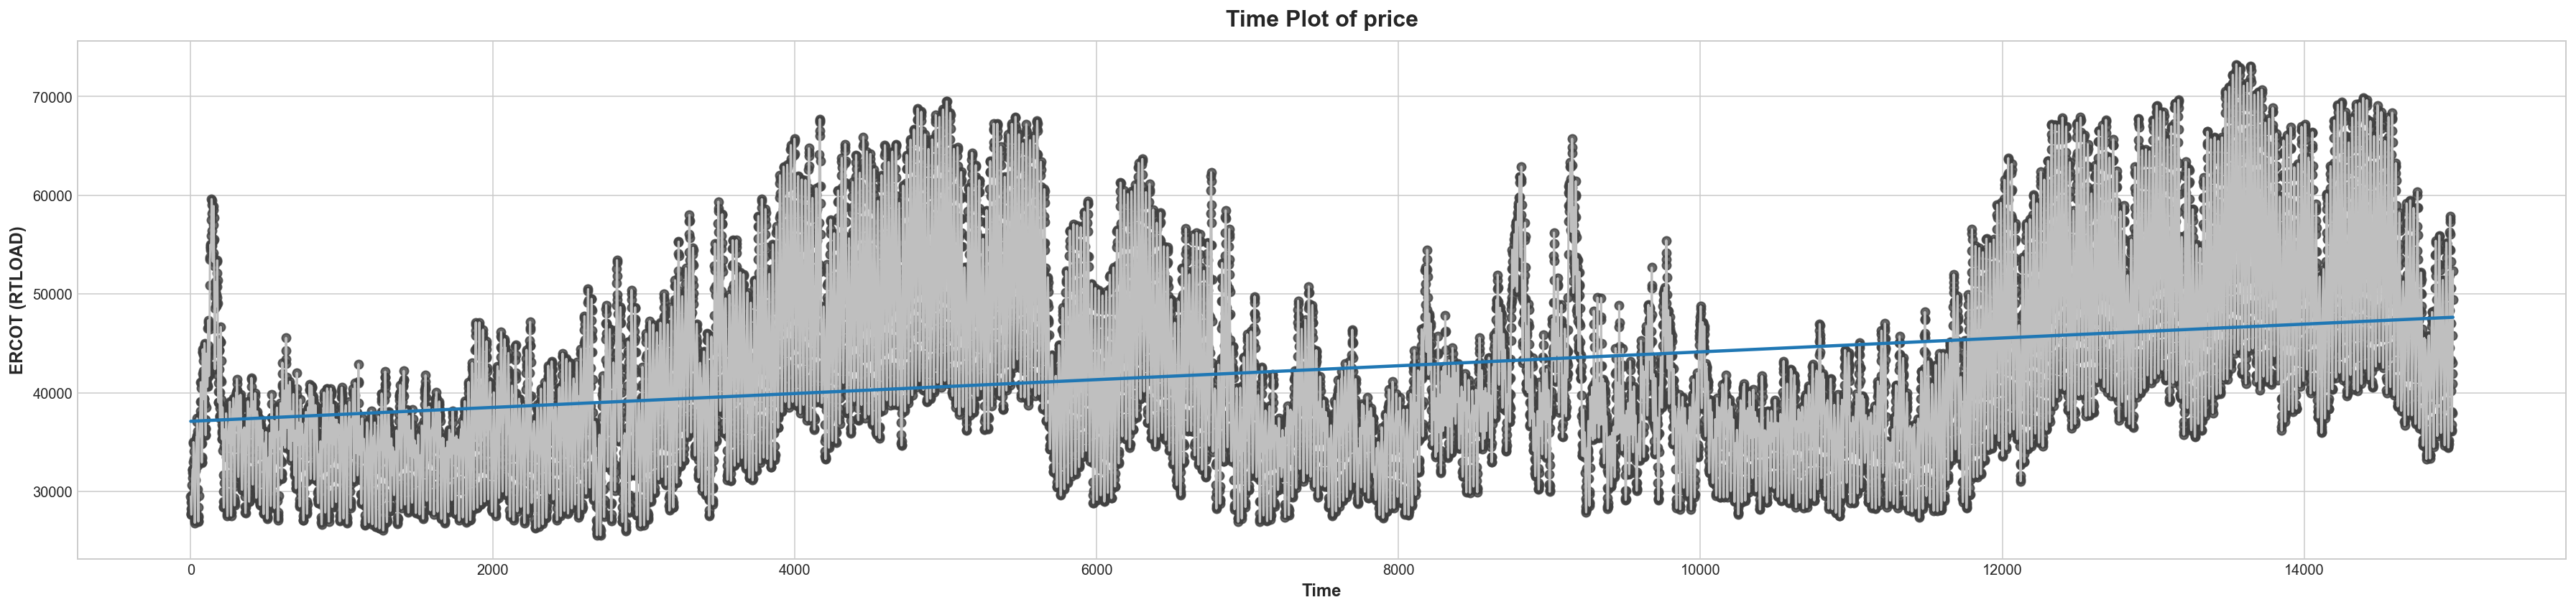

In [297]:
fig, ax = plt.subplots(figsize=(25, 6))

ax.plot('Time', 'ERCOT (RTLOAD)', data=df, color='0.75')
ax = sns.regplot('Time', 'ERCOT (RTLOAD)', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of price');

## 2.1 Lag features
* **Shift the observations of the target so that they appear to have occured later in time.**
* **Add 'lag' to the data.**

In [224]:
df['Lag_1'] = df['ERCOT (RTLOAD)'].shift(1)    # lags = 1
df = df.reindex()
df.head()

DATETIME  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
0 2017-01-01 01:00:00           23.3575           2155.31   
1 2017-01-01 02:00:00           21.4650           2313.81   
2 2017-01-01 03:00:00           20.7350           2587.68   
3 2017-01-01 04:00:00           20.2700           2748.65   
4 2017-01-01 05:00:00           20.1200           2757.49   

   ERCOT (GENERATION_SOLAR_RT)  ERCOT (RTLOAD)  HOURENDING  MARKETDAY  \
0                          0.0    29485.791355           1 2017-01-01   
1                          0.0    28911.565913           2 2017-01-01   
2                          0.0    28238.258175           3 2017-01-01   
3                          0.0    27821.000513           4 2017-01-01   
4                          0.0    27646.942413           5 2017-01-01   

   PEAKTYPE  MONTH  YEAR  Time         Lag_1  
0         1      1  2017     0           NaN  
1         1      1  2017     1  29485.791355  
2         1      1  2017     2  28911.565913  
3         1      1  2017     3  28238.258175  
4         1      1  2017     4  27821.000513

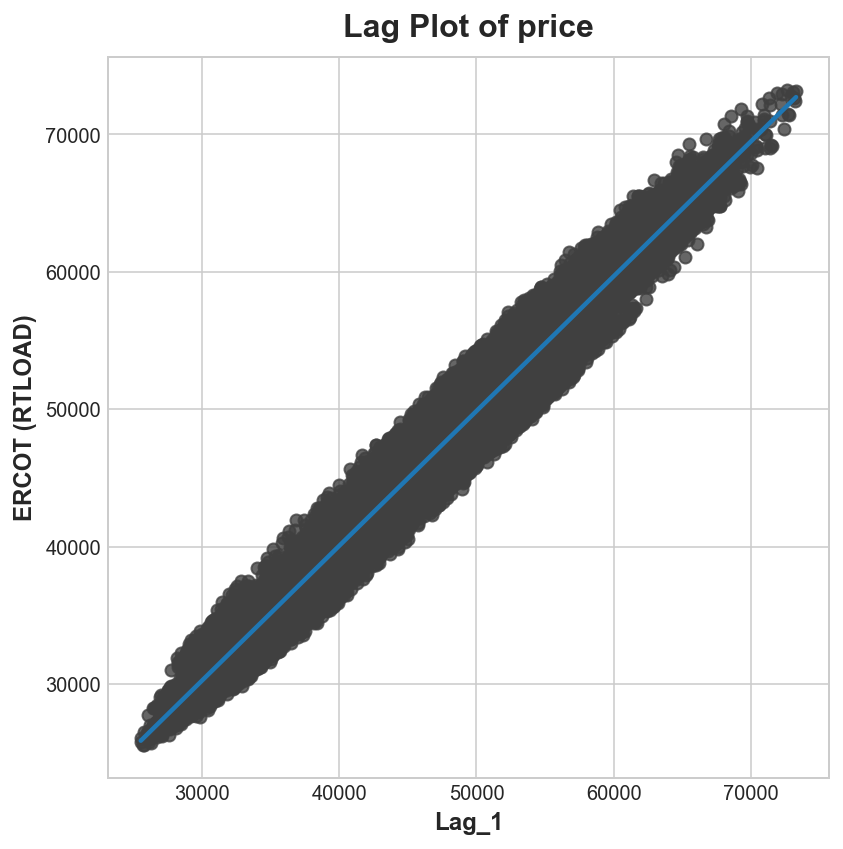

In [225]:
fig, ax = plt.subplots()

ax = sns.regplot(x='Lag_1', y='ERCOT (RTLOAD)', data=df, ci=None, scatter_kws=dict(color='0.25'))

ax.set_aspect('equal')
ax.set_title('Lag Plot of price');

## 2.2 Linear Regression
**Learns how to make a weighted sum from its input features.**

### 2.2.1 Lr predicted with `Time`

In [260]:
Time = df[['Time']]
y = df['ERCOT (RTLOAD)']

In [227]:
lr = LinearRegression()
lr.fit(Time, y)

y_pred = pd.Series(lr.predict(Time), index=Time.index)
y_pred    # predicted price with only time series

0        37103.219687
1        37103.922933
2        37104.626179
3        37105.329426
4        37106.032672
             ...     
14982    47638.550815
14983    47639.254061
14984    47639.957307
14985    47640.660554
14986    47641.363800
Length: 14986, dtype: float64

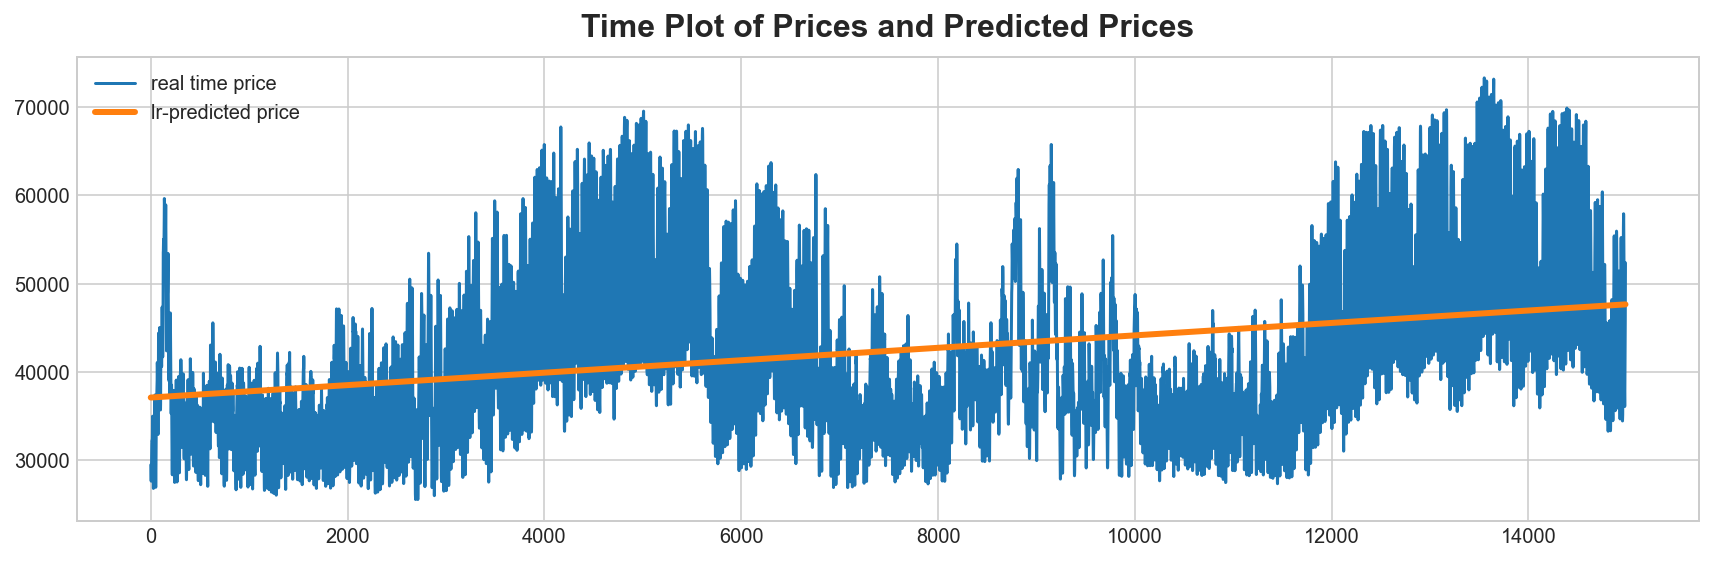

In [231]:
fig = plt.subplots(figsize=(12, 4))

ax = y.plot(label='real time price')
ax = y_pred.plot(ax=ax, linewidth=3, label='lr-predicted price')

ax.set_title('Time Plot of Prices and Predicted Prices')
plt.legend();

### 2.2.2 Lr predicted with `Lag` feature

In [161]:
Time_lag = df[['Lag_1']]
Time_lag.dropna(inplace = True)     # Drop missing values in the feature set

y_lag = df['ERCOT (RTLOAD)']
y_lag, Time_lag = y_lag.align(Time_lag, join='inner')     # Drop corresponding values in target

lr_lag = LinearRegression()
lr_lag.fit(Time_lag, y_lag)

y_pred_lag = pd.Series(lr_lag.predict(Time_lag), index=Time_lag.index)
y_pred_lag

1        29716.864551
2        29152.868330
3        28491.554860
4        28081.730204
5        27910.772766
             ...     
14982    40963.276583
14983    41912.127241
14984    43004.445817
14985    45723.313606
14986    49306.897996
Length: 14985, dtype: float64

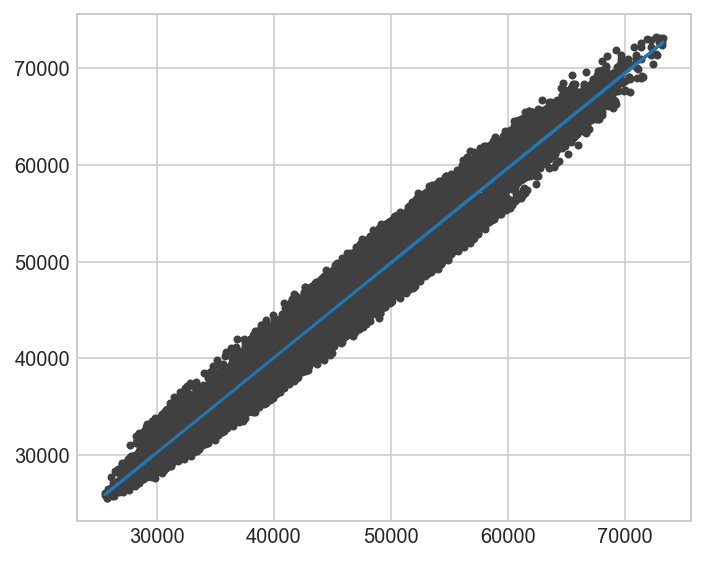

In [162]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(Time_lag['Lag_1'], y_lag, '.', color='0.25')
ax.plot(Time_lag['Lag_1'], y_pred_lag)

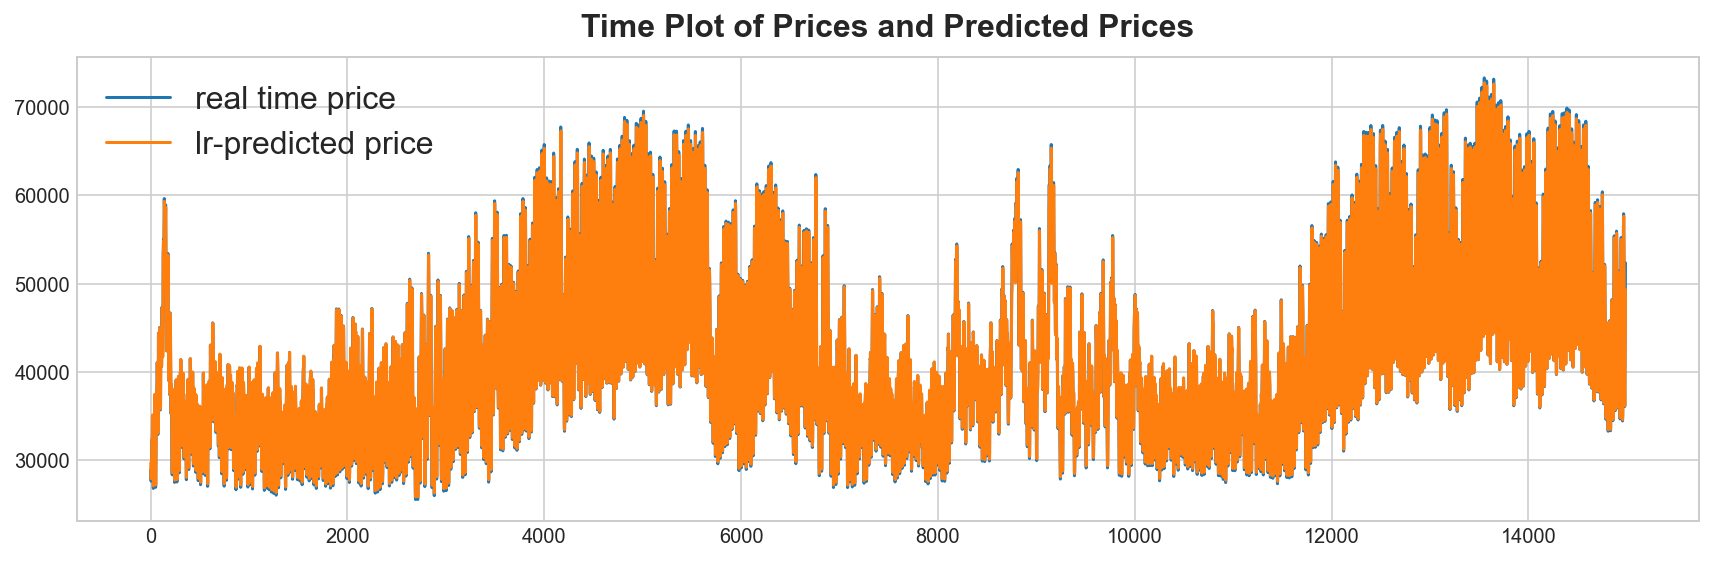

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

y_lag.plot(label='real time price')
y_pred_lag.plot(label='lr-predicted price')

ax.set_title('Time Plot of Prices and Predicted Prices')
plt.legend(fontsize=16)
plt.show();

**We can tell from the plot that the lr-predicted prices with `lag` is highly overlapping the real time price.**

## 2.3 Trend

### 2.3.1 Moving average

* **To smooth out any short-term fluctuations in the series so that only long-term changes remain.**
* **Compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side.**

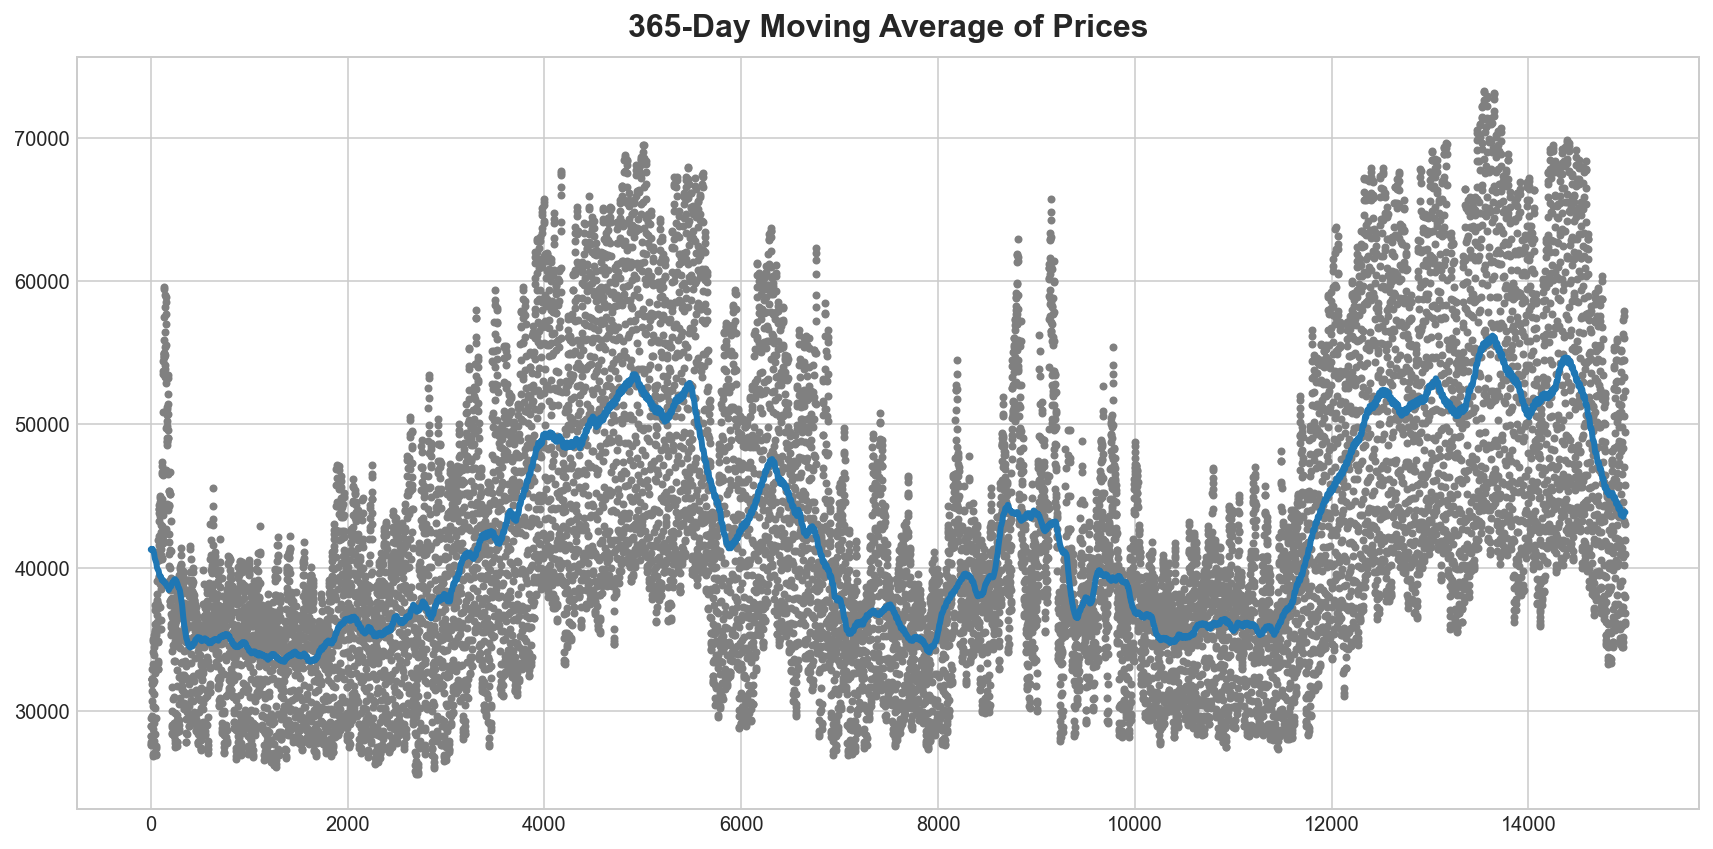

In [233]:
# Compute the average of the values within a sliding window of 365 days.

moving_average = df['ERCOT (RTLOAD)'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean 

ax = df['ERCOT (RTLOAD)'].plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3)

ax.set_title("365-Day Moving Average of Prices");

### 2.3.2 Frocasting Trend
**To avoid some tricky failure cases that can arise with time series and linear regression.**

In [234]:
dp = DeterministicProcess(
    index=df['ERCOT (RTLOAD)'].index,       
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # linear
    drop=True,           # drop terms if necessary to avoid collinearity
)

X_dp = dp.in_sample()
X_dp.head()

const  trend
0    1.0    1.0
1    1.0    2.0
2    1.0    3.0
3    1.0    4.0
4    1.0    5.0

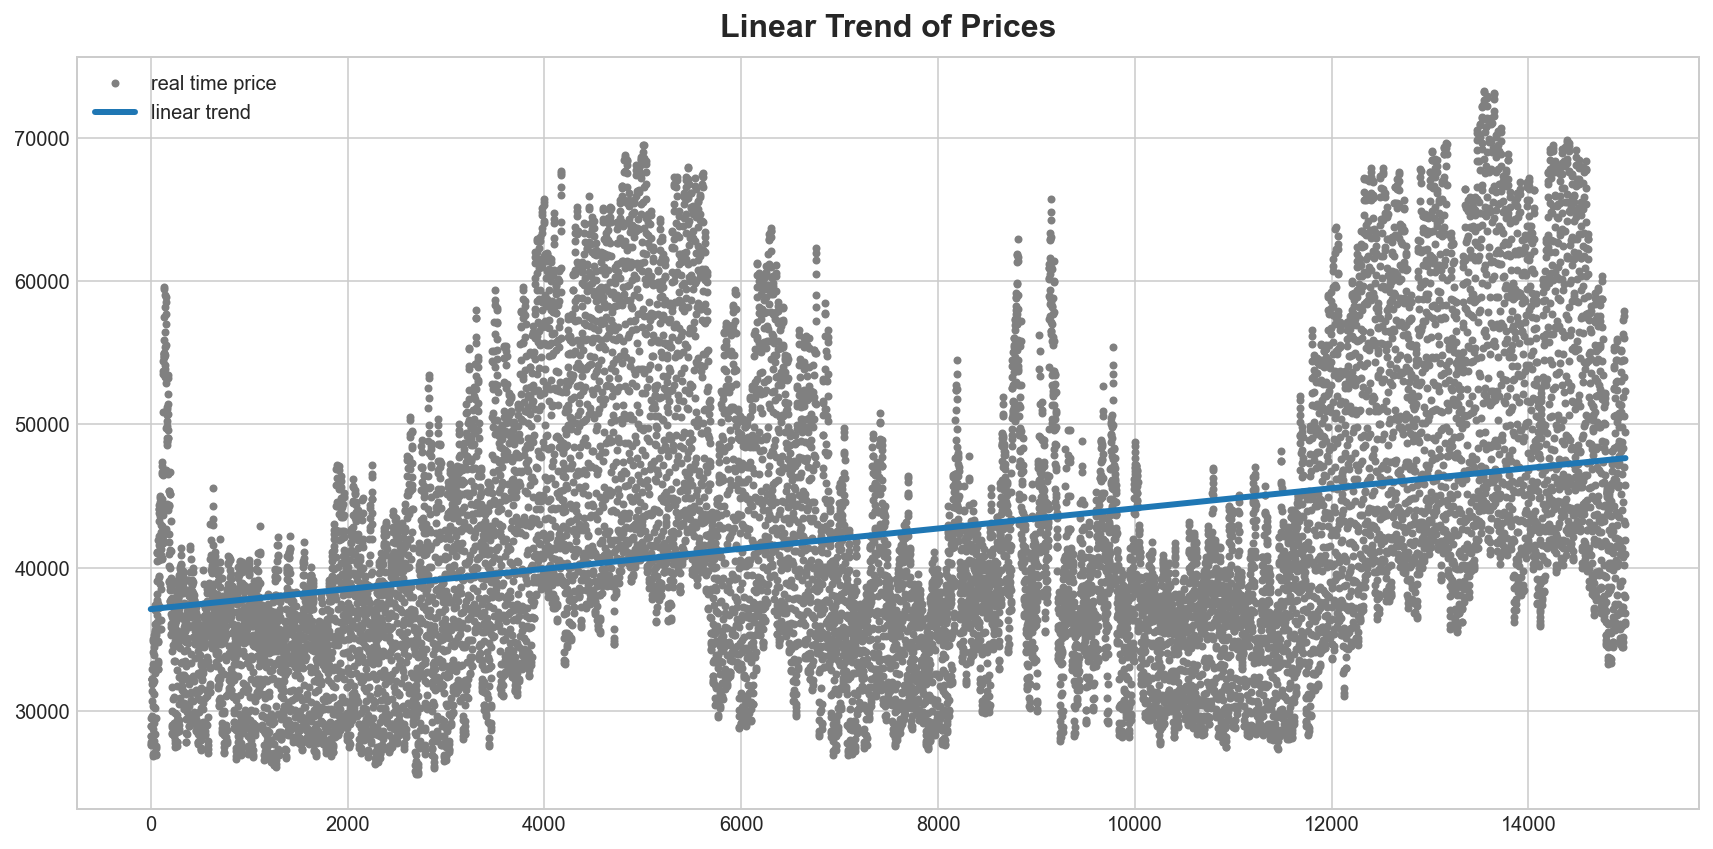

In [238]:
lr_dp = LinearRegression(fit_intercept=False)     # 'intercept' is the same as 'const' from DeterministicProcess
lr_dp.fit(X_dp, y)

y_pred_dp = pd.Series(lr_dp.predict(X_dp), index=X_dp.index)

ax = df['ERCOT (RTLOAD)'].plot(style=".", color="0.5", label='real time price')
y_pred_dp.plot(ax=ax, linewidth=3, label="linear trend")

ax.set_title('Linear Trend of Prices')
plt.legend();

### 2.3.3 Forecast trend for future 1000 steps

In [245]:
X_dp_out = dp.out_of_sample(steps=1000)
y_fore = pd.Series(lr_dp.predict(X_dp_out), index=X_dp_out.index)
y_fore.head()

14987    47642.067046
14988    47642.770292
14989    47643.473538
14990    47644.176785
14991    47644.880031
dtype: float64

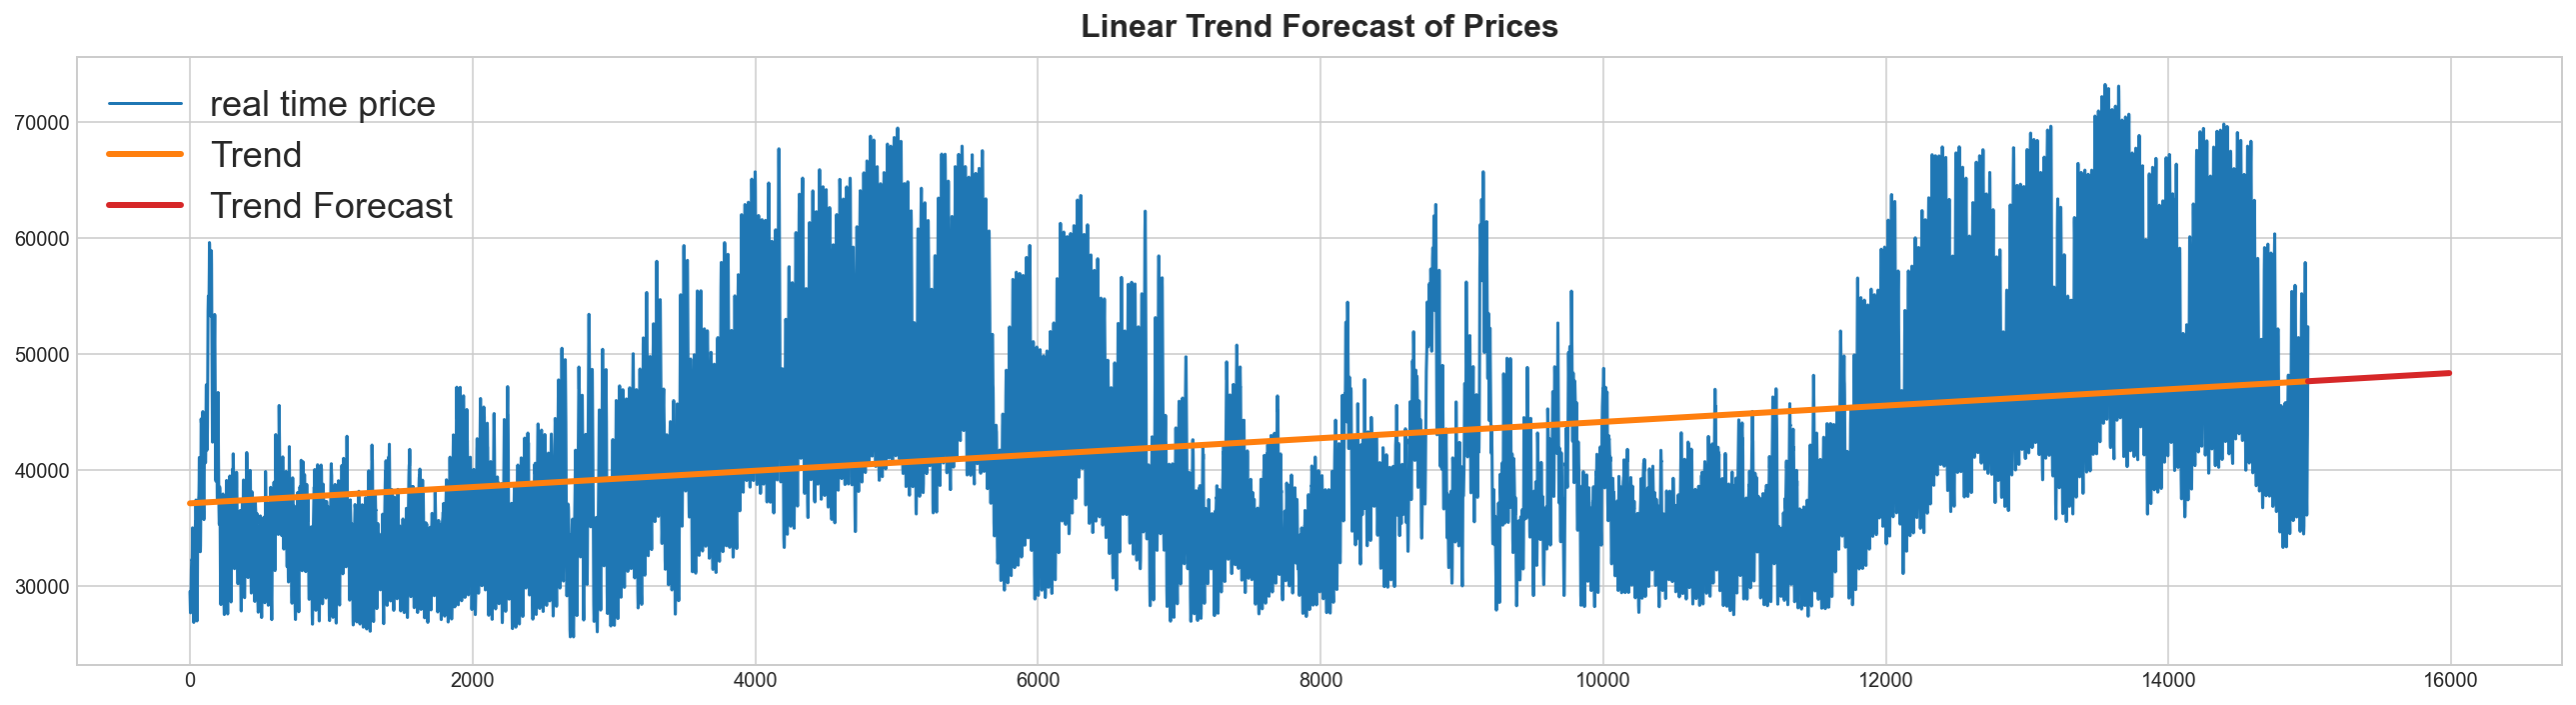

In [269]:
ax = df['ERCOT (RTLOAD)'].plot(label='real time price', figsize=(18,5))
ax = y_pred_dp.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")

ax.set_title('Linear Trend Forecast of Prices')
plt.legend(fontsize=18);

## 2.4 Seasonality
**Observe if there is a regular, periodic change in the mean of the series.**

In [ ]:
def seasonal_plot(X, y, period, freq, ax=None):
    """
    Draw the seasonality plot.
    """
    if ax is None:
        _, ax = plt.subplots()
        
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
        
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Draw the periodogram plot.
    """
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    
    if ax is None:
        _, ax = plt.subplots()
        
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

In [169]:
temp_df = df[['DATETIME', 'ERCOT (RTLOAD)']]
temp_df.set_index('DATETIME', inplace=True)
temp_df.head()

ERCOT (RTLOAD)
DATETIME                           
2017-01-01 01:00:00    29485.791355
2017-01-01 02:00:00    28911.565913
2017-01-01 03:00:00    28238.258175
2017-01-01 04:00:00    27821.000513
2017-01-01 05:00:00    27646.942413

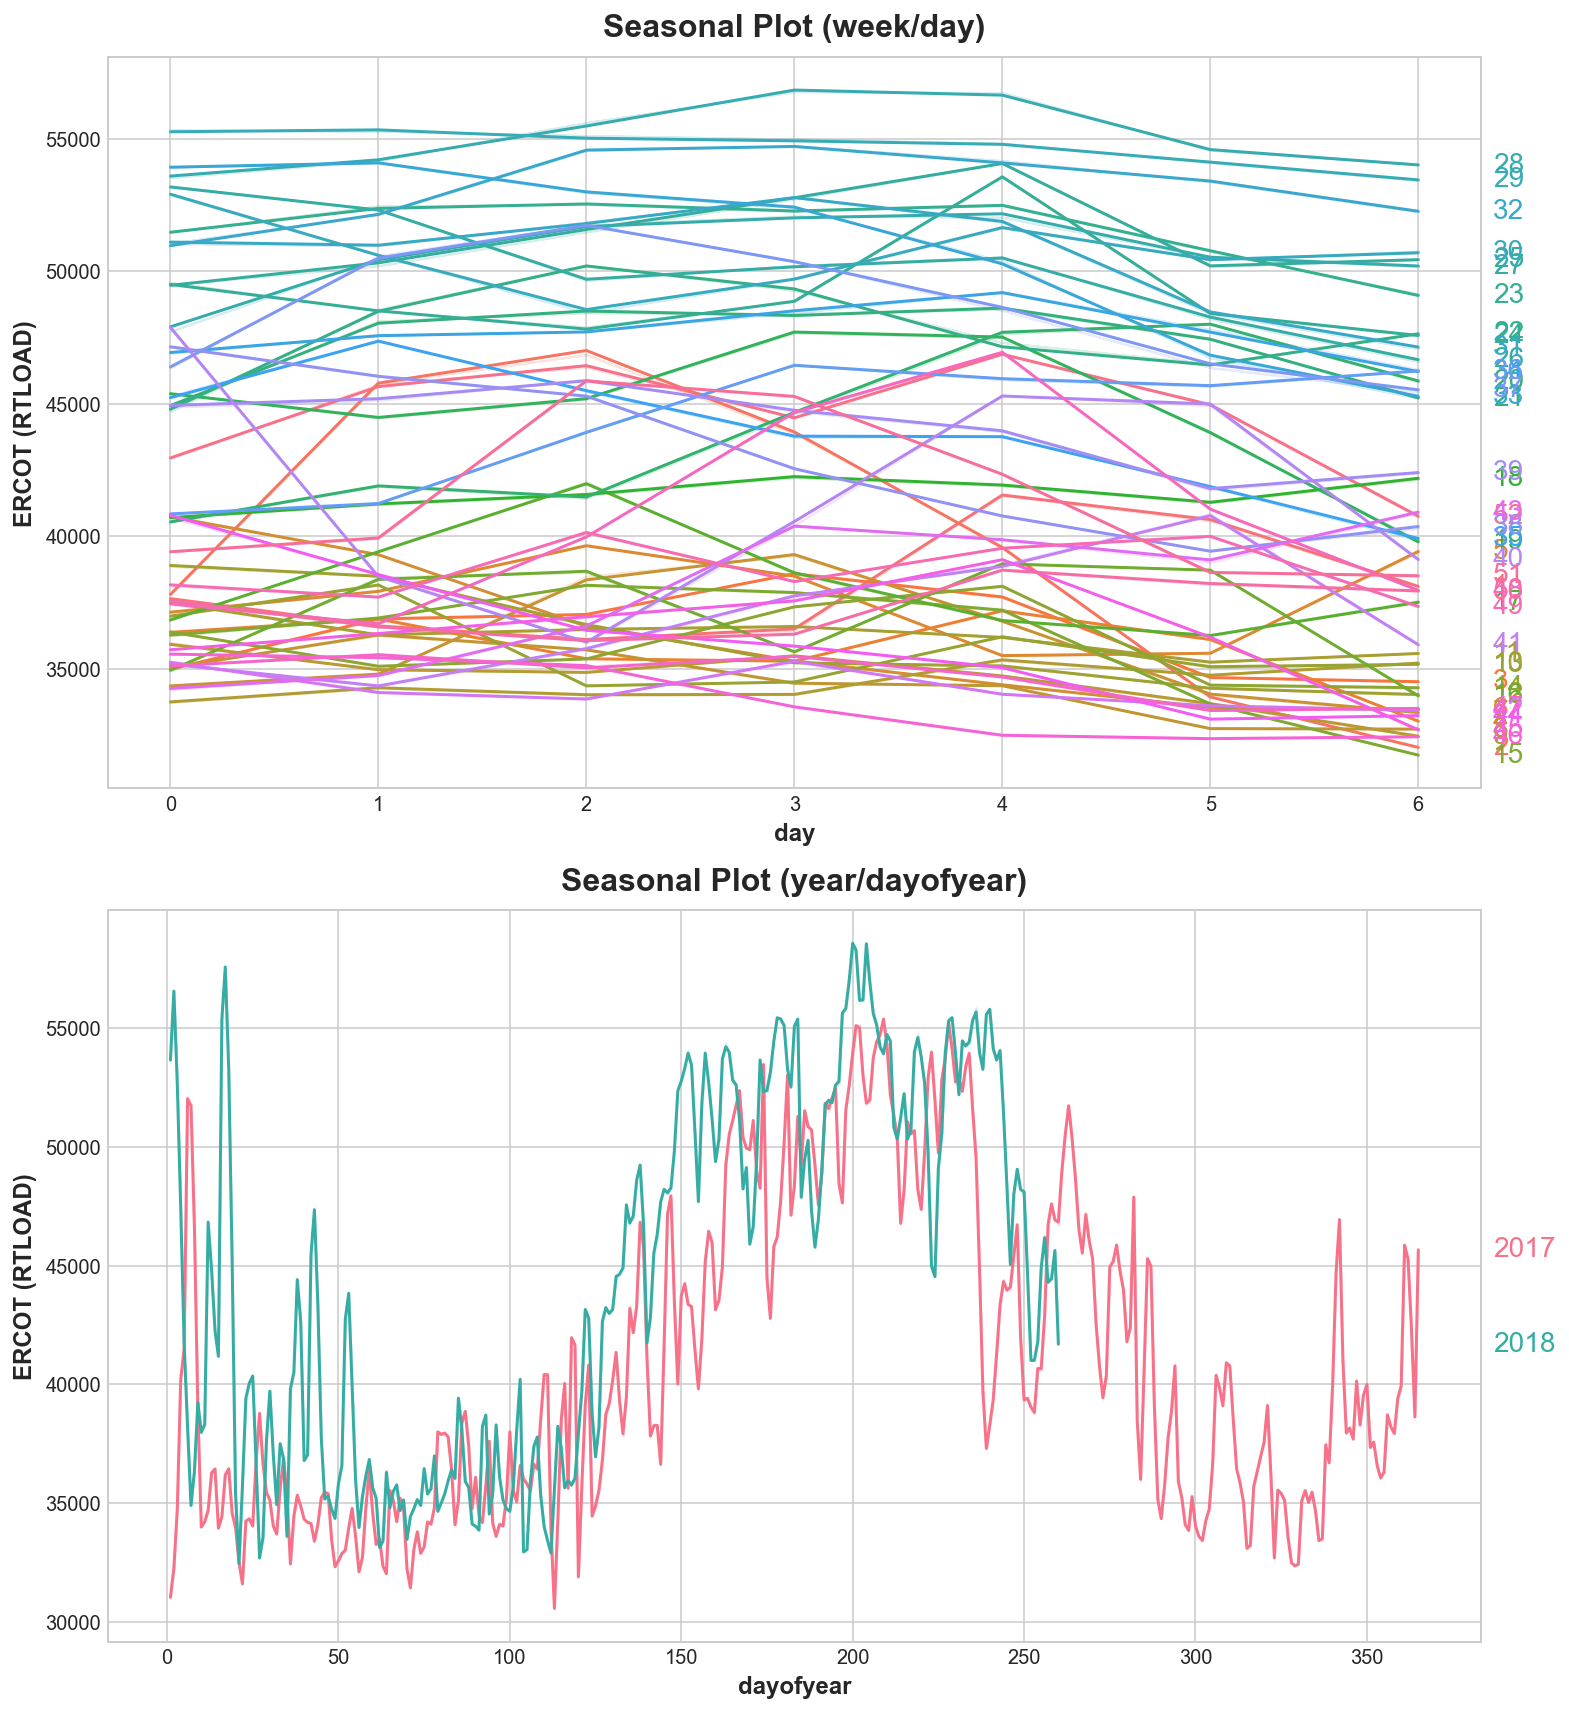

In [298]:
X_s = temp_df.copy()

# days within a week
X_s['day'] = X_s.index.dayofweek    # the x-axis (freq)
X_s['week'] = X_s.index.week        # the seasonal period (period)

# days within a year
X_s['dayofyear'] = X_s.index.dayofyear
X_s['year'] = X_s.index.year

fig, ax = plt.subplots(2, 1, figsize=(11, 12))

seasonal_plot(X_s, y="ERCOT (RTLOAD)", period="week", freq="day", ax=ax[0])
seasonal_plot(X_s, y="ERCOT (RTLOAD)", period="year", freq="dayofyear", ax=ax[1]);

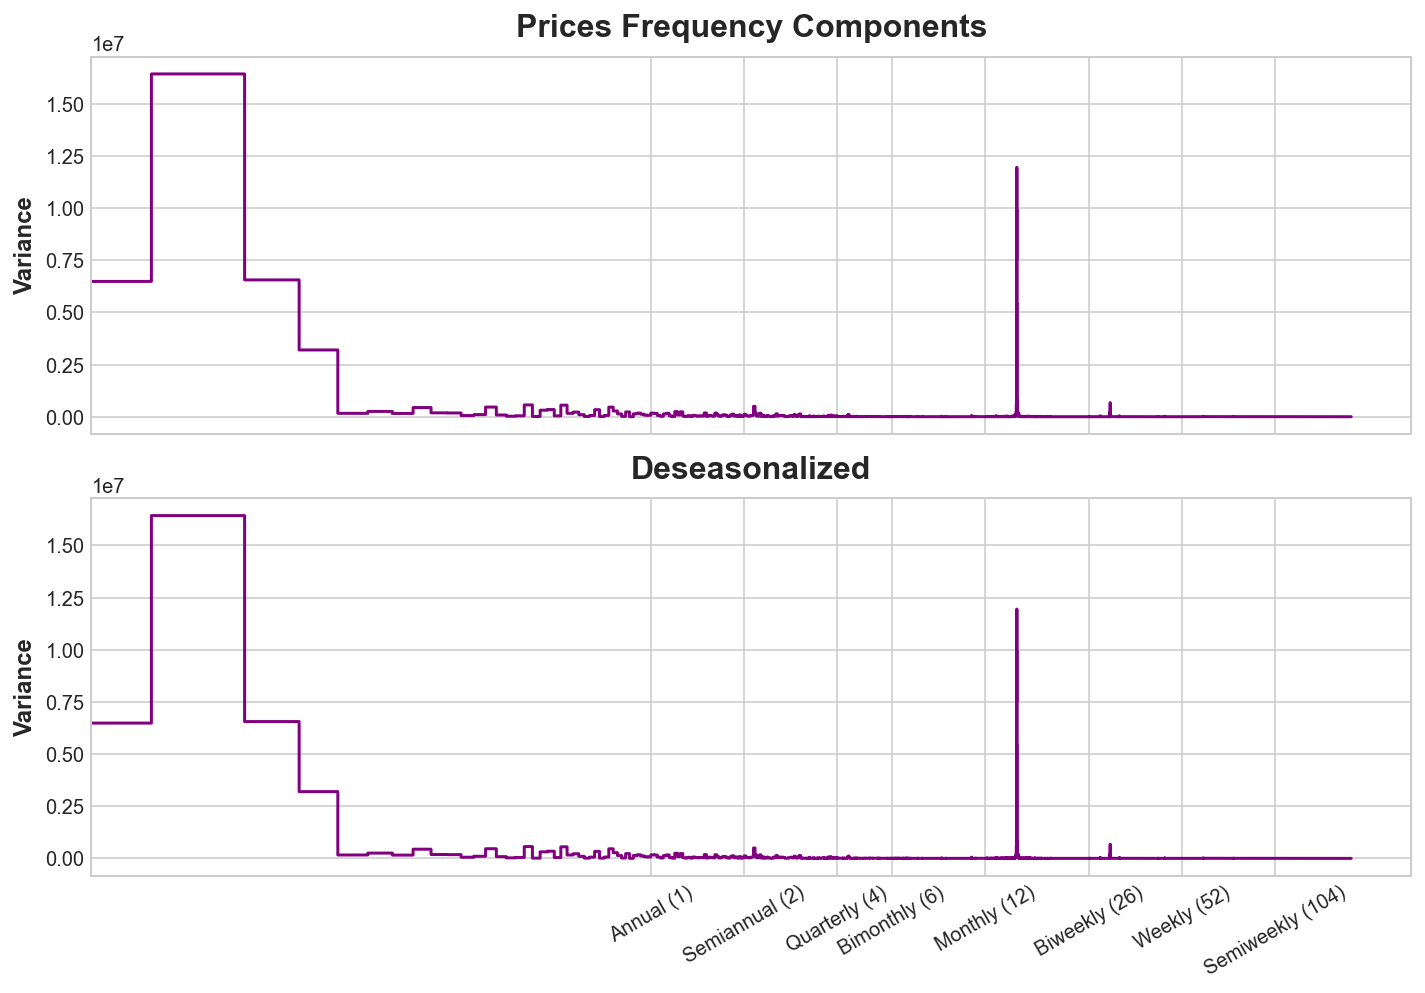

In [251]:
y_deseason = y - y_pred_dp

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

ax[0] = plot_periodogram(y, ax=ax1)
ax[0].set_title("Prices Frequency Components")

ax[1] = plot_periodogram(y_deseason, ax=ax2)
ax[1].set_title("Deseasonalized");

## 2.5 Take Time Series as a feature

### 2.5.1 Partial Autocorrelation
* **To measure of serial dependence.**
* **To choose lag feature. (The partial autocorrelation tells the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes.)**

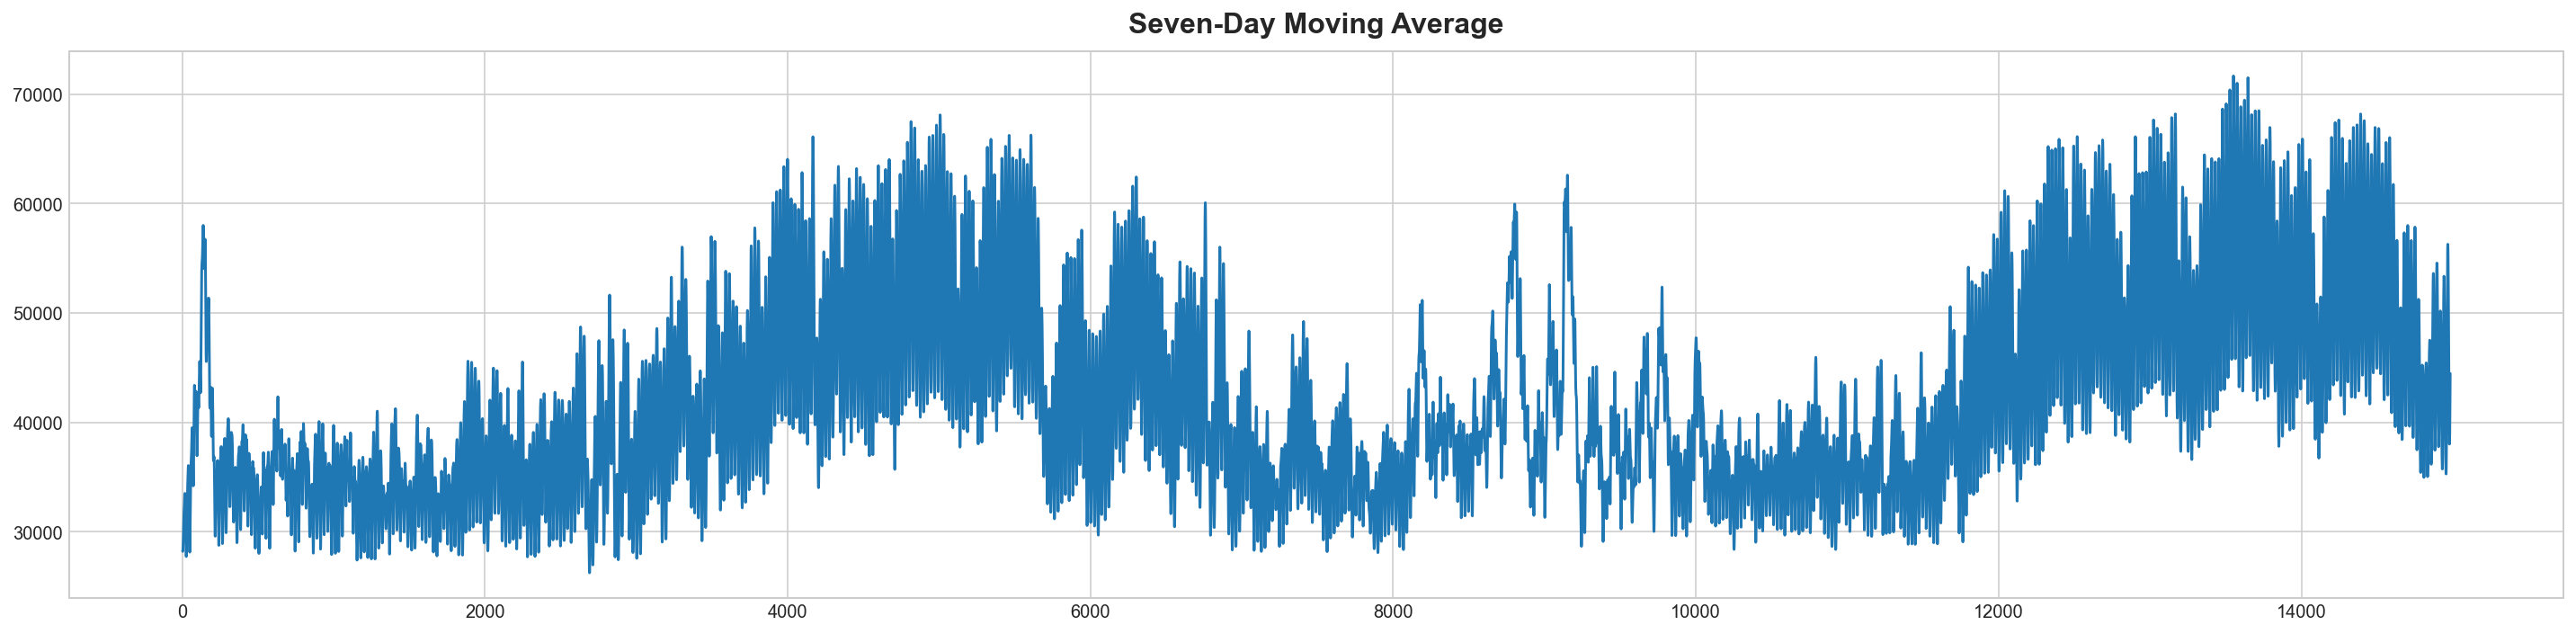

In [173]:
y_ma = y.rolling(7, center=True).mean()

ax = y_ma.plot(figsize=(20,5))
ax.set_title("Seven-Day Moving Average");

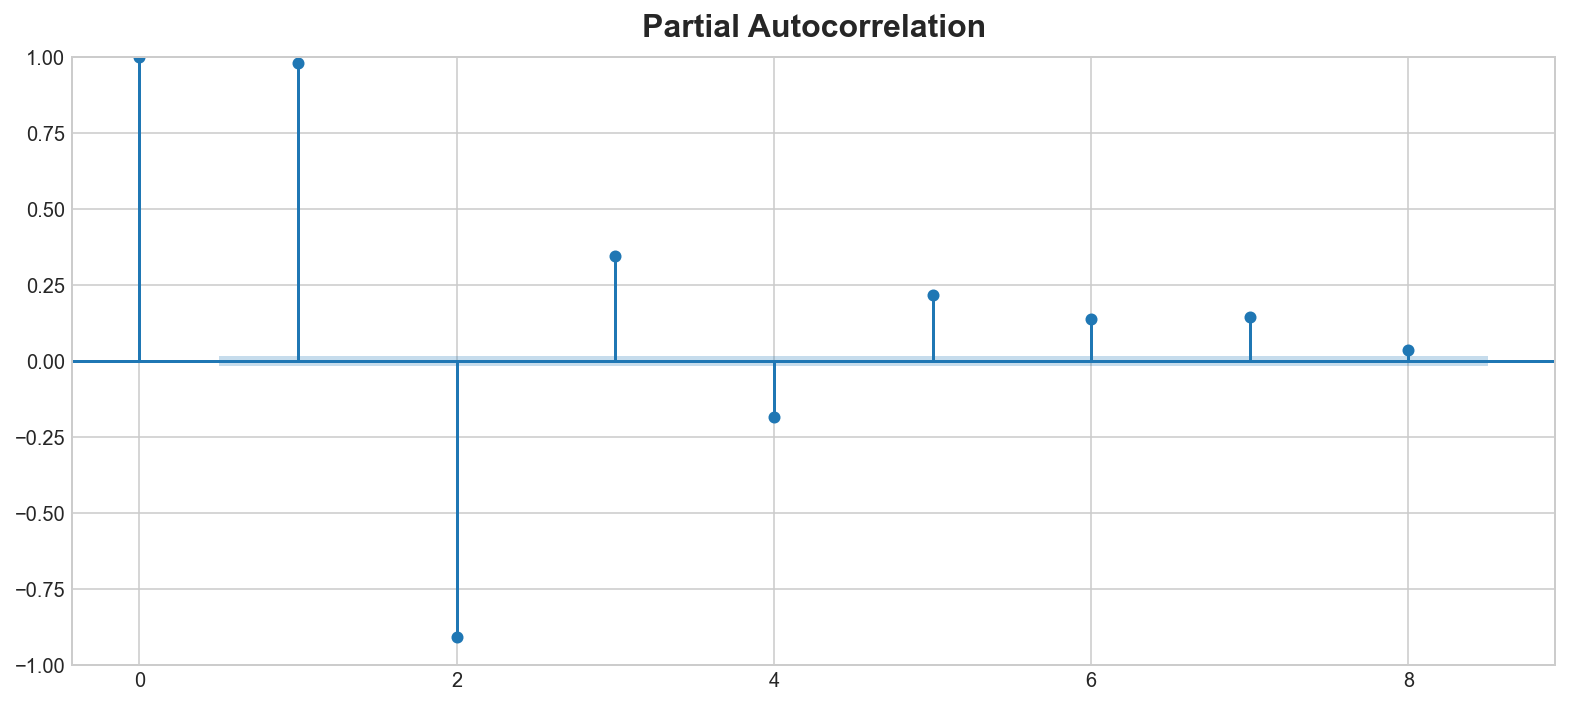

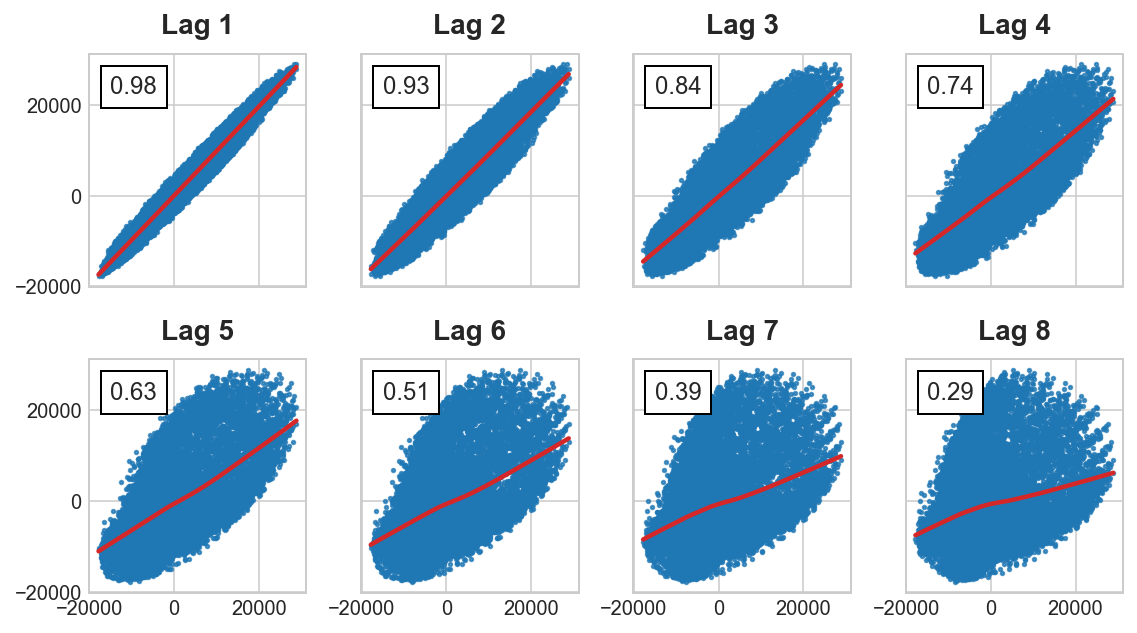

In [174]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

### 2.5.2 Forecasting Model with lag
**Choose lags = 1.**

In [261]:
X_lags = make_lags(y_deseason, lags=1)

# Create X with features:
X = pd.concat([X_lags,                            # lags for time series
               df['HB_NORTH (RTLMP)'],            # ERCOT real-time hourly actual load
               df['ERCOT (WIND_RTI)'],            # ERCOT real-time hourly wind generation
               df['ERCOT (GENERATION_SOLAR_RT)'], # ERCOT real-time solar generation
               df.PEAKTYPE,                       # peaktype of the time
               df.MONTH,                          # month
               df.HOURENDING,                     # hour of the day
               df.YEAR],                          # year
              axis=1)

X = X.iloc[1:, :]              # delete the first row with lag=NaN
y = df['ERCOT (RTLOAD)'][1:]

X

y_lag_1  HB_NORTH (RTLMP)  ERCOT (WIND_RTI)  \
1     -7617.428332           21.4650           2313.81   
2     -8192.357020           20.7350           2587.68   
3     -8866.368004           20.2700           2748.65   
4     -9284.328913           20.1200           2757.49   
5     -9459.090259           19.7925           3032.06   
...            ...               ...               ...   
14982 -6701.667569           20.8600           3195.52   
14983 -5736.310815           22.7675           2605.50   
14984 -4624.884061           31.0600           2034.80   
14985 -1857.407307           29.6700              0.00   
14986  1790.469446           33.6607              0.00   

       ERCOT (GENERATION_SOLAR_RT)  PEAKTYPE  MONTH  HOURENDING  YEAR  
1                             0.00         1      1           2  2017  
2                             0.00         1      1           3  2017  
3                             0.00         1      1           4  2017  
4                             0.00         1      1           5  2017  
5                             0.00         1      1           6  2017  
...                            ...       ...    ...         ...   ...  
14982                         2.04         0      9           8  2018  
14983                       111.59         0      9           9  2018  
14984                       261.65         0      9          10  2018  
14985                       464.88         0      9          11  2018  
14986                         0.00         0      9          12  2018  

[14985 rows x 8 columns]

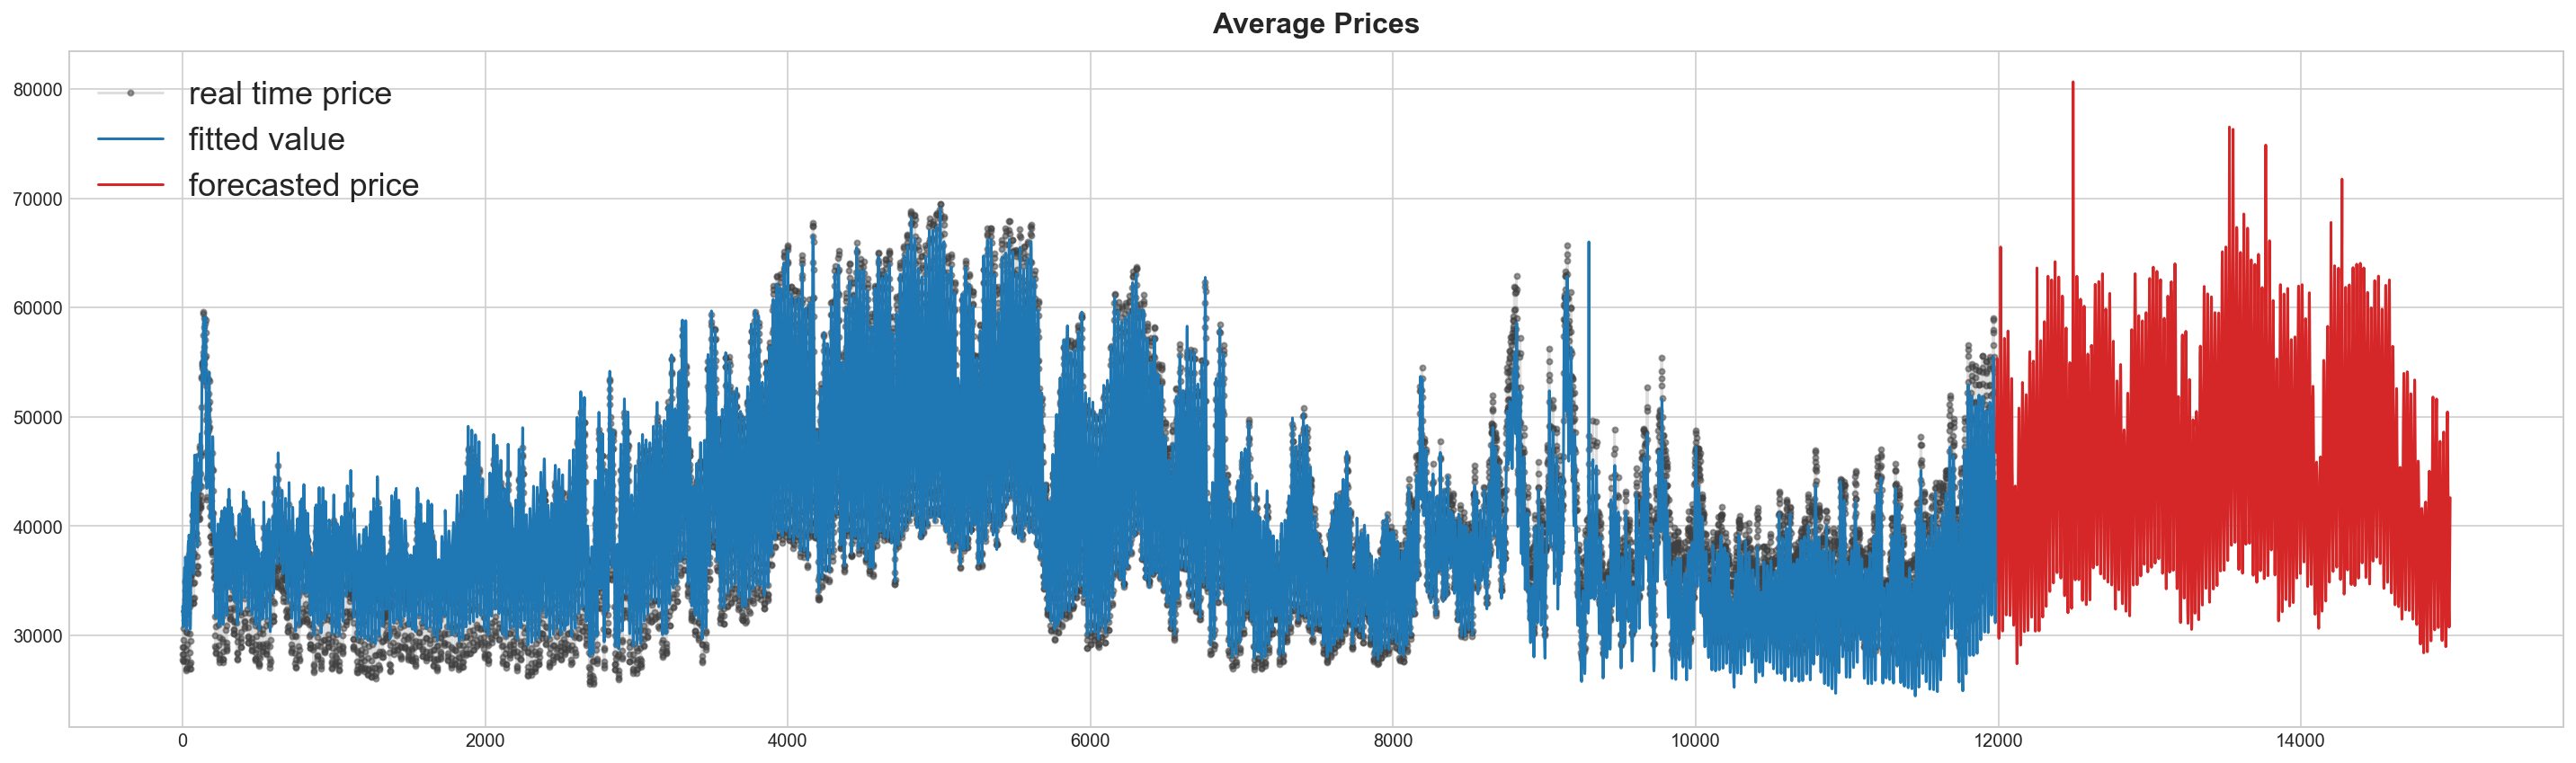

In [267]:
# split the data, with 3000 rows to be the validation data. 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=3000, shuffle=False)

# sets the y-intercept to 0
# if fit_intercept=True, the y-intercept will be determined by the line of best fit.
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

fig, ax = plt.subplots(figsize=(20, 6))

ax = y[:len(y)-3000].plot(**plot_params, alpha=0.5, label="real time price")
ax = y_fit.plot(ax=ax, label="fitted value", color='C0')
ax = y_pred.plot(ax=ax, label="forecasted price", color='C3')

ax.set_title('Average Prices')
ax.legend(fontsize=18);

### 2.5.3 Evaluation - Root Mean Squared Log Error (RMSLE)

In [272]:
rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5

print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

Training RMSLE: 0.06791
Validation RMSLE: 0.11357


**The training RMSLE is 0.068 and validation RMSLE is 0.11. Both are relatively small, proving that this model gives a good forecasting!!**

## Notes

### 'Cross-validation' for Time Series:

In [ ]:
tscv = TimeSeriesSplit(n_splis=5)

i = 1
score = []
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train[tr_index], X_train[val_index]
    y_tr, y_val = y_train[tr_index], y_train[val_index]
    
    for mf in np.linspace(100, 150, 6):
        for ne in np.linspace(50, 100, 6):
            for md in np.linspace(20, 40, 5):
                for msl in np.linspace(30, 100, 8):
                    rfr = RandomForestRegressor(
                        max_features_int(mf), 
                        n_estimators=int(ne), 
                        max_depth=int(md), 
                        min_samples_leaf=int(msl))
                    rfr.fit(X_tr, y_tr)
                    score.append([i, mf, ne, md, 
                                  msl, rfr.score(X_val, y_val)])
    i+=1